<div style="background: #6883bc; color: white; padding: 10px; font-size: 18pt; line-height: 1.5">
<b><center>Анализ маркетинговых расходов Яндекс.Афиша<b>
    
</div>

## Оглавление

[Описание задачи](#description)  
[Импорты и настройки](#imports)

[Шаг 1. Изучение общей информации](#start) 
* [1.1 Открытие файла с данными, первый взгляд на данные](#open)
* [1.2 Обработка названий столбцов](#names)
* [1.3 Обзор уникальных значений](#unique)      
 - [1.3.1 Уникальные значения в таблице visits_log](#unique_visits_log)
 - [1.3.2 Уникальные значения в таблице orders_log](#unique_orders_log)
 - [1.3.3 Уникальные значения в таблице costs](#unique_costs)    

[Вывод по шагу 1](#start_conclusion)

[Шаг 2. Предобработка данных](#preprocessing)  
* [2.1 Приведение типов](#types)
* [2.2 Добавление расчетных данных](#adding_data)  
 - [2.2.1 Расчетные данные в таблице visits_log](#adding_data_to_visits_log)
 - [2.2.2 Расчетные данные в таблице orders_log](#adding_data_to_orders_log)
 - [2.2.3 Расчетные данные в таблице costs](#adding_data_to_costs)    
[Вывод по шагу 2](#preprocessing_conclusion)

[Шаг 3. Анализ данных](#analysis)
* [3.1 Продуктовые метрики](#product)
  - [3.1.1 DAU / WAU / MAU](#dau_wau_mau)
  - [3.1.2 Количество посещений сайта](#visits)
  - [3.1.3 Продолжительность посещений сайта](#duration)
  - [3.1.4 Retention Rate](#retention_rate)
* [3.2 Метрики электронной коммерции](#e-commerce)
  - [3.2.1 Время до совершения покупки](#delta)
  - [3.2.2 Среднее количество покупок на одного покупателя](#avg_buys)
  - [3.2.3 Средний чек](#avg_check)
  - [3.2.4 LTV](#ltv)
* [3.3 Маркетинговые метрики](#marketing)  
  - [3.3.1 Расходы на маркетинг](#marketing_costs)
  - [3.3.2 CAC](#cac)
  - [3.3.3 ROMI](#romi)    
[Вывод по шагу 3](#analysis_conclusion)

[Общий вывод](#total_conclusion)

------

<a id='description'></a>
## Описание задачи

Яндекс.Афиша — сервис по продаже билетов на развлекательные мероприятия.


Цель -  проанализировать расходы на маркетинг, чтобы отказаться от невыгодных источников трафика и перераспределить бюджет.

Задачи: 
- проанализировать как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

<a id='imports'></a>
### Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

In [3]:
sns.set(style="ticks")

In [4]:
def first_look(df):
    display(df.info())
    display(df.head(5))
    display(df.describe())
    display('Доля пустых строк:', df.isna().mean())
    display('Количество дублирующихся строк:', df.duplicated().sum())

<a id='start'></a>
## Шаг 1. Изучение общей информации

<a id='open'></a>
### Шаг 1.1 Открытие файла с данными, первый взгляд на данные

In [5]:
visits_log = pd.read_csv('/datasets/visits_log.csv')

In [6]:
first_look(visits_log)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Source Id,Uid
count,359400.00,359400.00
mean,3.75,9202556994354921472.00
std,1.92,5298432824659611648.00
min,1.00,11863502262781.00
25%,3.00,4613406732167550976.00
50%,4.00,9227412908740601856.00
75%,5.00,13728237011236173824.00
max,10.00,18446676030785673216.00


'Доля пустых строк:'

Device      0.00
End Ts      0.00
Source Id   0.00
Start Ts    0.00
Uid         0.00
dtype: float64

'Количество дублирующихся строк:'

0

Таблица `visits_log` содержит 359400 записей, в 5 столбцах:
- `Uid` - уникальный идентификатор пользователя,
- `Device` - утройство пользователя,
- `Start Ts` - дата и время начала сессии,
- `End Ts` - дата и время окончания сессии,
- `Source Id` - источник трафика.    
Наименования столбцов приведем к нижнему регистру, заменим пробелы на нижнее подчеркивание.
Пропущенных значений и дубликатов нет. 
Приведем тип данных в столбцах `Start Ts` и `End Ts` к типу datetime.

In [7]:
orders_log = pd.read_csv('/datasets/orders_log.csv')

In [8]:
first_look(orders_log)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,Revenue,Uid
count,50415.00,50415.00
mean,5.00,9098160634289729536.00
std,21.82,5285741550834715648.00
min,0.00,313578113262317.00
25%,1.22,4533566627250599936.00
50%,2.50,9102273602618561536.00
75%,4.89,13682901980465401856.00
max,2633.28,18446167067214817280.00


'Доля пустых строк:'

Buy Ts    0.00
Revenue   0.00
Uid       0.00
dtype: float64

'Количество дублирующихся строк:'

0

Таблица `orders_log` содержит 50415 записей, в 3 столбцах:
- `Uid` - уникальный идентификатор пользователя,
- `Buy Ts` - дата и время заказа,
- `Revenue` - сумма заказа в у.е.    
Наименования столбцов приведем к нижнему регистру, заменим пробелы на нижнее подчеркивание.
Пропущенных значений и дубликатов нет. 
Приведем тип данных в столбце `Buy Ts` к типу datetime.

In [9]:
costs = pd.read_csv('/datasets/costs.csv')

In [10]:
first_look(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


,source_id,costs
count,2542.00,2542.00
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,1788.28


'Доля пустых строк:'

source_id   0.00
dt          0.00
costs       0.00
dtype: float64

'Количество дублирующихся строк:'

0

Таблица `costs` содержит 2542 записей, в 3 столбцах:
- `source_id` - ,
- `dt` - дата проведения рекламной кампании,
- `costs` - расходы на рекламную кампанию в у.е.    
Пропущенных значений и дубликатов нет. 
Приведем тип данных в столбце `dt` к типу datetime.

<a id='names'></a>
### Шаг 1.2 Обработка названий столбцов

In [11]:
for df in [visits_log, orders_log]:
    df.columns = df.columns.str.lower().str.replace(' ','_')

In [12]:
visits_log.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [13]:
orders_log.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

<a id='unique'></a>
### Шаг 1.3 Обзор уникальных значений

<a id='unique_visits_log'></a>
#### Шаг 1.3.1 Уникальные значения в таблице visits_log

In [15]:
visits_log['device'].value_counts(normalize=True)

desktop   0.73
touch     0.27
Name: device, dtype: float64

Почти 3/4 всех посещений производятся со стационарных компьютеров и только чуть больше четверти с мобильных устройств.

In [16]:
visits_log['source_id'].value_counts().sort_index()

1      34121
2      47626
3      85610
4     101794
5      66905
6          6
7         36
9      13277
10     10025
Name: source_id, dtype: int64

In [17]:
13277/len(visits_log)

0.03694212576516416

Text(0, 0.5, 'Количество пользователей, шт.')

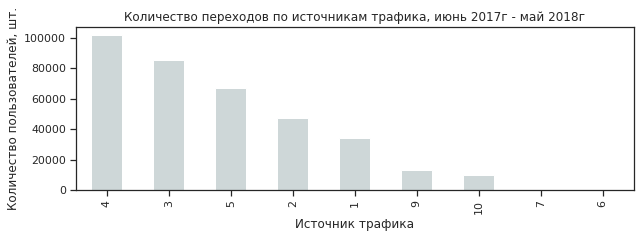

In [18]:
visits_log['source_id'].value_counts().plot(kind='bar', figsize=(10,3), color='#ced7d8')
plt.title('Количество переходов по источникам трафика, июнь 2017г - май 2018г')
plt.xlabel('Источник трафика')
plt.ylabel('Количество пользователей, шт.')

На сайт люди заходят из разных источников трафика (9 наименований), при этом наиболее популярным является источник под №4, а вот источники 6 и 7 вообще почти не используются.

In [19]:
visits_log.groupby('uid')['source_id'].count().describe()

count   228169.00
mean         1.58
std          4.65
min          1.00
25%          1.00
50%          1.00
75%          1.00
max        893.00
Name: source_id, dtype: float64

Распределение количества источников трафика по пользователям имеет тяжелый хвост справа, что на графике ящиков с усами мы бы увидели как выбросы. Средний пользователь использует 1 источник трафика.

In [20]:
print('Количество уникальных пользователей:', visits_log['uid'].nunique())

Количество уникальных пользователей: 228169


In [21]:
print('Логи посещений содержат данные с {} до {}'.
      format(visits_log['start_ts'].min(), visits_log['start_ts'].max()))

Логи посещений содержат данные с 2017-06-01 00:01:00 до 2018-05-31 23:59:00


<a id='unique_orders_log'></a>
#### Шаг 1.3.2 Уникальные значения в таблице orders_log

In [22]:
print('Количество уникальных покупателей:', orders_log['uid'].nunique())

Количество уникальных покупателей: 36523


In [23]:
print('На одного покупателя в год приходится в среднем {:.2f} заказа'.
      format((len(orders_log) / orders_log['uid'].nunique())))

На одного покупателя в год приходится в среднем 1.38 заказа


In [24]:
print('Логи заказов содержат данные с {} до {}'.format(orders_log['buy_ts'].min(), orders_log['buy_ts'].max()))

Логи заказов содержат данные с 2017-06-01 00:10:00 до 2018-06-01 00:02:00


Уберем заказы, осуществленные 1 июня 2018г, чтобы данные были представлены ровно на календарный год и соответствовали периоду логов посещений.

In [25]:
orders_log = orders_log[orders_log['buy_ts'] < '2018-06-01']

In [26]:
print('Суммарная стоимость всех заказов с 01.06.2017 по 31.05.2018: {:.2f} у.е.'.
      format(orders_log['revenue'].sum()))

Суммарная стоимость всех заказов с 01.06.2017 по 31.05.2018: 252053.78 у.е.


<a id='unique_costs'></a>
#### Шаг 1.3.3 Уникальные значения в таблице costs

In [27]:
print('Файл с расходами на маркетинг содержит данные с {} до {}'.format(costs['dt'].min(), costs['dt'].max()))

Файл с расходами на маркетинг содержит данные с 2017-06-01 до 2018-05-31


In [28]:
print('Суммарные затраты на рекламные кампании с 01.06.2017 по 31.05.2018: {} у.е.'.
      format(costs['costs'].sum()))

Суммарные затраты на рекламные кампании с 01.06.2017 по 31.05.2018: 329131.62 у.е.


In [29]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

За представленный период происходили вложения в источники трафика, по которым осуществлялись переходы пользователей, за исключением источников под № 6 и №7. В каждом из оставшихся источников рекламные кампании длятся на протяжении почти всего календарного года, за исключением 1-2 дней.

Text(0, 0.5, 'Затраты на маркетинг, у.е.')

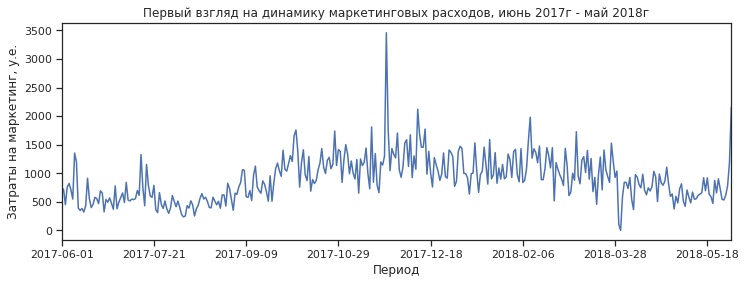

In [30]:
fig, ax = plt.subplots(figsize=(12,4))
costs.groupby('dt')['costs'].sum().plot()
plt.title('Первый взгляд на динамику маркетинговых расходов, июнь 2017г - май 2018г')
plt.xlabel('Период')
plt.ylabel('Затраты на маркетинг, у.е.')

Видим, что затраты распределены в течение года неравномерно, имеется явный пик около новогодних праздников и провалы в период летних каникул.

<a id='start_conclusion'></a>
## Вывод по шагу 1

Для анализа эффективности маркетинговых мероприятий будут использованы 3 источника данных за период с начала июня 2017г по конец мая 2018г.:
- данные по визитам пользователей на сайт Яндекс.Афиши,
- данные по заказам клиентов,
- информация по маркетинговым затратам.   

В предоставленных данных был обнаружен заказ, не относящийся к выбранному периоду исследования, который мы удалили. В остальном данные не содержат явных проблем - пропуски и дубликаты отсутствуют.   
Наименования столбцов датасетов по визитам и заказам привели в необходимый вид - к нижнему регистру, с использованием нижнего подчеркивания вместо пробелов.   
Столбцы с датой и временем в каждой из таблиц приведем в явном виде к формату datetime, а также добавим расчетные данные для проведения дальнейшего анализа.

<a id='preprocessing'></a>
## Шаг 2. Предобработка данных

<a id='types'></a>
### Шаг 2.1 Приведение типов

In [31]:
for df in (visits_log, orders_log, costs):
    for col in df.filter(regex='.*_ts|dt.*').columns:
        df[col] = pd.to_datetime(df[col])

<a id='adding_data'></a>
### Шаг 2.2 Добавление расчетных данных

<a id='adding_data_to_visits_log'></a>
#### Шаг 2.2.1 Расчетные данные в таблице visits_log

Добавим в таблицу с посещениями длительность каждой из сессий в секундах

In [32]:
visits_log['duration'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds

In [33]:
visits_log['duration'].describe()

count   359400.00
mean       643.51
std       1016.33
min          0.00
25%        120.00
50%        300.00
75%        840.00
max      84480.00
Name: duration, dtype: float64

In [34]:
len(visits_log[visits_log['duration'] == 0]) / len(visits_log)

0.0995937673900946

Минимальное количество времени, проводимое пользователями на сайте, составляет 0 секунд, количество таких сессий составляет около 10% всех посещений, вероятно, это случайные открытия страницы в браузере. Распределение длительности посещений скошено влево и имеет длинный хвост справа. Медианный пользователь проводит  на сайте 5 минут за сессию.

In [35]:
visits_log.groupby('device')['duration'].mean()

device
desktop   703.95
touch     479.62
Name: duration, dtype: float64

Средняя продолжительность десктопной сессии в 1,5 выше, чем с мобильных устройств

Для удобства расчетов добавим информацию по дате, неделе, месяцу и году в отдельных столбцах таблицы логов посещений.

In [36]:
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_week'] = visits_log['start_ts'].dt.week
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_date'] = visits_log['start_ts'].dt.date

Определим первую дату, когда пользователь зашел на сайт, и сформируем когорты пользователей по этому признаку.

In [37]:
first_activity_date = visits_log.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits_log = visits_log.join(first_activity_date, on='uid')

In [38]:
visits_log['first_activity_month'] = visits_log['first_activity_date'].astype('datetime64[M]')

In [39]:
visits_log['cohort_lifetime'] = ((visits_log['session_date'].astype('datetime64[M]') - visits_log['first_activity_month']) / np.timedelta64(1, 'M')).round()

<a id='adding_data_to_orders_log'></a>
#### Шаг 2.2.2 Расчетные данные в таблице orders_log

Аналогично таблице посещений, определим первую дату заказа каждого клиента и сформируем когорты покупателей по этому признаку.

In [40]:
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')

In [41]:
first_order_date = orders_log.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders_log = orders_log.merge(first_order_date, on='uid')
orders_log['first_order_month'] = orders_log['first_order_date'].astype('datetime64[M]')

In [42]:
orders_log['cohort_lifetime'] = ((orders_log['order_month'] - orders_log['first_order_month']) / np.timedelta64(1, 'M')).round()

<a id='adding_data_to_costs'></a>
#### Шаг 2.2.3 Расчетные данные в таблице costs

Для анализа информации по источникам трафика определим для каждого из покупателей "главный источник", в качестве которого выберем источник, с которого пользователь зашел на сайт при его самом первом посещении.

In [43]:
source_by_users = visits_log.sort_values('start_ts').groupby('uid')['source_id'].first()

In [44]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

In [45]:
orders_by_source = orders_log.merge(source_by_users, on='uid')
orders_by_source.drop(columns=['buy_ts', 'first_order_date'], inplace=True)

<a id='preprocessing_conclusion'></a>
## Вывод по шагу 2

Столбцы с датой и временем в каждой из таблиц были приведены в явном виде к формату datetime.

Для дальнейшего анализа в таблицы были добавлены новые столбцы.    
В таблицу `visits_log`:
- `duration` - длительность сессии в секундах,
- `session_year`, `session_month`, `session_week`, `session_date` -  год, месяц, неделя и дата посещения,
- `first_activity_date`, `first_activity_month` - дата и месяц, когда пользователь впервые зашел на сайт,
- `cohort_lifetime` - возраст когорты, сформированной по месяцу первого посещения

In [46]:
visits_log.head(3)

,device,end_ts,source_id,start_ts,uid,duration,session_year,session_week,session_month,session_date,first_activity_date,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017,51,12,2017-12-20,2017-12-20 17:20:00,2017-12-01,0.00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018,8,2,2018-02-19,2018-02-19 16:53:00,2018-02-01,0.00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,26,7,2017-07-01,2017-07-01 01:54:00,2017-07-01,0.00


Новые стоблцы в таблице orders_log:
- `order_month` - месяц, в котором был сделан заказ,
- `first_order_date`, `first_order_month` - дата и месяц первого заказа,
- `cohort_lifetime` - возраст когорты, сформированной по месяцу первого заказа

In [47]:
orders_log.head(3)

,buy_ts,revenue,uid,order_month,first_order_date,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0.00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0.00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0.00


Новые стоблцы в таблице costs:
- `dt_month` - месяц маркетинговой кампании

In [48]:
costs.head(3)

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01


Для анализа маркетинговых затрат на одного покупателя для каждого источника трафика сформировали датасет `orders_by_source` со столбцами:
- `uid` -  уникальный идентификатор пользователя,
- `source_id` - истоник трафика,
- `revenue` - сумма по заказам клиента, перешедшего с определенного источника трафика,
- `order_month` - месяц заказа клиента, перешедшего с определенного источника трафика,
- `first_order_month` - месяц первого заказа клиента, перешедшего с определенного источника трафика,
- `cohort_lifetime` - возраст когорты, сформированной по месяцу первого заказа клиента, перешедшего с определенного источника трафика

In [49]:
orders_by_source.head(3)

,revenue,uid,order_month,first_order_month,cohort_lifetime,source_id
0,17.00,10329302124590727494,2017-06-01,2017-06-01,0.00,1
1,0.55,11627257723692907447,2017-06-01,2017-06-01,0.00,2
2,0.37,17903680561304213844,2017-06-01,2017-06-01,0.00,2


<a id='analysis'></a>
## Шаг 3. Анализ данных

<a id='product'></a>
### Шаг 3.1 Продуктовые метрики

<a id='dau_wau_mau'></a>
#### Шаг 3.1.1 DAU / WAU / MAU

In [50]:
dau = int(visits_log.groupby('session_date')['uid'].nunique().mean())
dau

907

Text(0, 0.5, 'Количество уникальных пользователей, шт.')

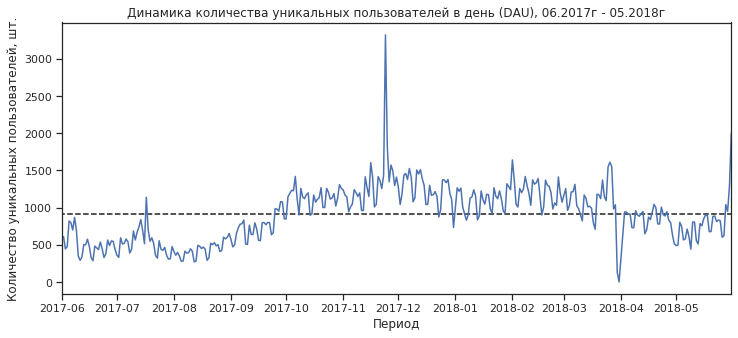

In [51]:
plt.figure(figsize=(12,5))
visits_log.groupby('session_date')['uid'].nunique().plot()
plt.hlines(dau, 0, visits_log['session_date'].max(), linestyles='dashed')
plt.title('Динамика количества уникальных пользователей в день (DAU), 06.2017г - 05.2018г')
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')

In [52]:
wau = int(visits_log.groupby(['session_year', 'session_week']).agg({'uid' : 'nunique'}).mean())
wau

5716

Text(0, 0.5, 'Количество уникальных пользователей, шт.')

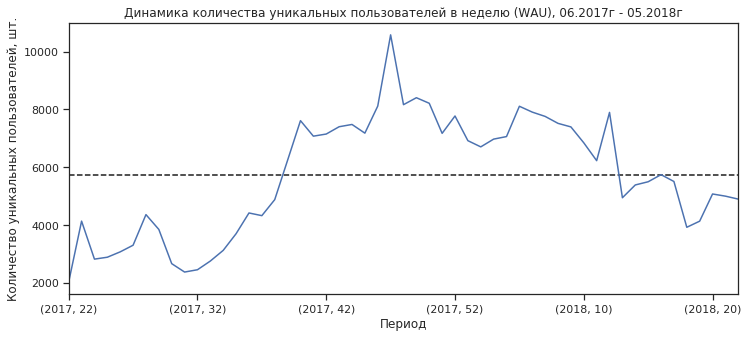

In [53]:
fig, ax = plt.subplots(figsize=(12,5))
visits_log.groupby(['session_year', 'session_week']).agg({'uid' : 'nunique'}).plot(ax=ax)
ax.get_legend().remove()
plt.hlines(wau, 0, visits_log['session_date'].max(), linestyles='dashed')
plt.title('Динамика количества уникальных пользователей в неделю (WAU), 06.2017г - 05.2018г')
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')

In [54]:
mau = int(visits_log.groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'}).mean())
mau

23228

Text(0, 0.5, 'Количество уникальных пользователей, шт.')

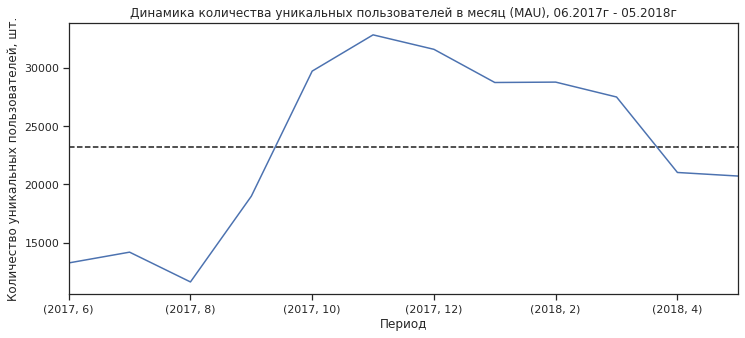

In [55]:
fig, ax = plt.subplots(figsize=(12,5))
visits_log.groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'}).plot(ax=ax)
ax.get_legend().remove()
plt.hlines(mau, 0, visits_log['session_date'].max(), linestyles='dashed')
plt.title('Динамика количества уникальных пользователей в месяц (MAU), 06.2017г - 05.2018г')
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')

В течение года по количеству уникальных пользователей можно выделить 2 больших периода:
1. с октября по апрель, когда DAU/WAU/MAU выше среднего значения с пиком в районе новогодних праздников
2. с апреля по октябрь, где зачение  DAU/WAU/MAU ниже среднего и достигает минимальных значений в летние месяцы

Посмотрим на стабильность аудитории, рассчитаем sticky factors

In [56]:
print('Sticky factor за месяц: {:.0%}'.format(dau / mau))

Sticky factor за месяц: 4%


In [57]:
print('Sticky factor за неделю: {:.0%}'.format(dau / wau))

Sticky factor за неделю: 16%


Sticky factor за месяц на уровне 4% говорит о довольно низкой вовлеченности пользователей, клиентская база за месяц весьма разнообразна, что подтверждается здравым смыслом - конечно, Яндекс.Афиша - это не соцсеть, где проходят лучшие годы некоторых пользователей, на мероприятия в основном люди ходят время от времени, а заядлых театралов единицы.

<a id='visits'></a>
#### Шаг 3.1.2 Количество посещений сайта

In [58]:
print('На каждого пользователя приходится в среднем {:.1f} заходов на сайт за год'.
      format(len(visits_log) / visits_log['uid'].nunique()))

На каждого пользователя приходится в среднем 1.6 заходов на сайт за год


In [59]:
sessions_per_user = visits_log.groupby(['session_date']).agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

In [60]:
print('На одного пользователя среди посещающих сайт в конкретный день приходится в среднем {} сессий'.
      format(round(sessions_per_user['sessions_per_user'].mean(), 2)))

На одного пользователя среди посещающих сайт в конкретный день приходится в среднем 1.08 сессий


Text(0, 0.5, 'Количество сессий, шт.')

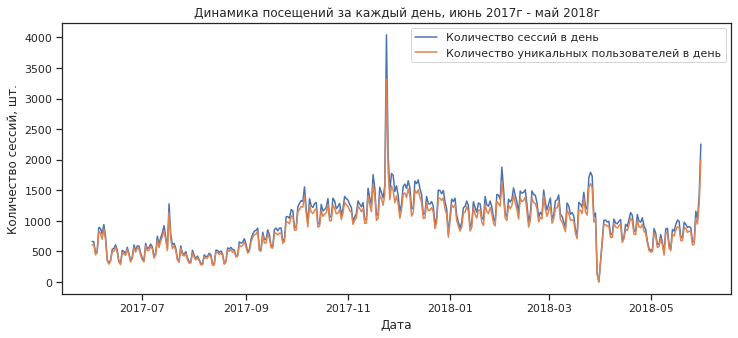

In [61]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(visits_log.groupby('session_date').agg({'uid' : 'count'}), label='Количество сессий в день')
ax.plot(visits_log.groupby('session_date').agg({'uid' : 'nunique'}), label='Количество уникальных пользователей в день')
ax.legend()
plt.title('Динамика посещений за каждый день, июнь 2017г - май 2018г')
plt.xlabel('Дата')
plt.ylabel('Количество сессий, шт.')

Видим, что графики расположены очень близко, значит, среднее количество сессий на 1 юзера в день, составляющее в среднем единицу, отражает картину по всему анализиуемому периоду. То есть те, кто заходят на сайт в конкретный день, в среднем делают это единожды.

Text(0, 0.5, 'Количество сессий на пользователя, шт.')

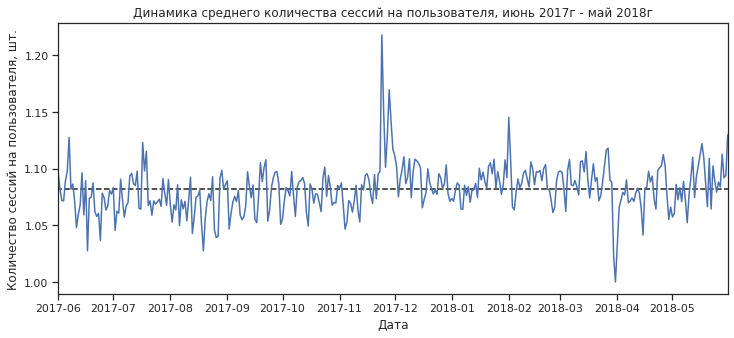

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
sessions_per_user['sessions_per_user'].plot()
plt.hlines(sessions_per_user['sessions_per_user'].mean(), 0, visits_log['session_date'].max(), linestyles='dashed')
plt.title('Динамика среднего количества сессий на пользователя, июнь 2017г - май 2018г')
plt.xlabel('Дата')
plt.ylabel('Количество сессий на пользователя, шт.')

Разброс относительно среднего значения количества сессий за каждый день не слишком велик - от 1 до 1.2 штук на пользователя.

<a id='duration'></a>
#### Шаг 3.1.3 Продолжительность посещений сайта

Text(0, 0.5, 'Количество пользователей, шт.')

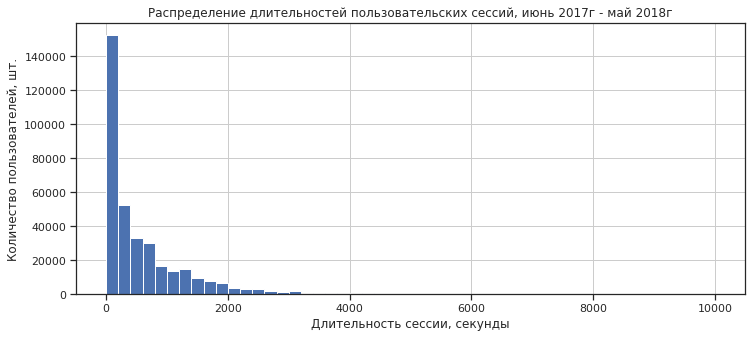

In [63]:
visits_log['duration'].hist(bins=50, range=(0, 10000), figsize=(12,5))
plt.title('Распределение длительностей пользовательских сессий, июнь 2017г - май 2018г')
plt.xlabel('Длительность сессии, секунды')
plt.ylabel('Количество пользователей, шт.')

Распределение длительностей пользовательских сессий не является нормальным, для оценки средней длительности возьмем моду

In [64]:
visits_log['duration'].mode()

0    60
dtype: int64

In [65]:
visits_log.groupby(['session_year', 'session_month'])['duration'].agg(lambda x:x.value_counts().index[0])

session_year  session_month
2017          6                60
              7                60
              8                60
              9                60
              10               60
              11               60
              12               60
2018          1                60
              2                60
              3                60
              4                60
              5                60
Name: duration, dtype: int64

Типичная пользовательская сессия длится 60 секунд и это значение стабильно в течение анализируемого периода.

<a id='retention_rate'></a>
#### Шаг 3.1.4 Retention Rate

Для расчета показателя Retention Rate сформируем когорты пользователей по дате первого входа на сайт

In [66]:
(visits_log.
 pivot_table(index='first_activity_month', columns='cohort_lifetime', values='uid', aggfunc='nunique').
 fillna(''))

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.00,1043.00,713.00,814.00,909.00,947.00,809.00,766.00,694.00,674.00,539.00,596.00
2017-07-01,13140.00,737.00,674.00,738.00,765.00,633.00,596.00,601.00,510.00,376.00,361.00,
2017-08-01,10181.00,783.00,640.00,639.00,510.00,448.00,370.00,402.00,284.00,265.00,,
2017-09-01,16704.00,1428.00,1156.00,847.00,658.00,632.00,599.00,404.00,381.00,,,
2017-10-01,25977.00,2042.00,1357.00,1012.00,890.00,837.00,555.00,529.00,,,,
2017-11-01,27248.00,2133.00,1202.00,1054.00,919.00,638.00,594.00,,,,,
2017-12-01,25268.00,1410.00,960.00,786.00,512.00,481.00,,,,,,
2018-01-01,22624.00,1351.00,890.00,565.00,458.00,,,,,,,
2018-02-01,22197.00,1267.00,565.00,446.00,,,,,,,,


Наиболее массовыми являются когорты, сформированные с октября по март, что подтвержает увиденную ранее сезонность в спросе на мероприятия, в среднем когорты в сезон и не-сезон отличаются по размеру на 40%.

In [67]:
cohorts = visits_log.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [68]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

In [69]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [70]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0.00,13259,13259,1.00
1,2017-06-01,1.00,1043,13259,0.08
2,2017-06-01,2.00,713,13259,0.05
3,2017-06-01,3.00,814,13259,0.06
4,2017-06-01,4.00,909,13259,0.07


Ограничим вывод показателя retention rate возрастом когорт больше нулевого периода, чтобы на тепловой карте нагляднее увидеть изменение показателя во времени

In [71]:
retention_pivot = (cohorts[cohorts['cohort_lifetime'] > 0]
                   .pivot_table(index='first_activity_month', columns='cohort_lifetime', 
                                values='retention', aggfunc='sum'))

In [72]:
retention_pivot.fillna('')

cohort_lifetime,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_activity_month,,,,,,,,,,,
2017-06-01,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,
2017-08-01,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,,
2017-09-01,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,,,
2017-10-01,0.08,0.05,0.04,0.03,0.03,0.02,0.02,,,,
2017-11-01,0.08,0.04,0.04,0.03,0.02,0.02,,,,,
2017-12-01,0.06,0.04,0.03,0.02,0.02,,,,,,
2018-01-01,0.06,0.04,0.02,0.02,,,,,,,
2018-02-01,0.06,0.03,0.02,,,,,,,,


Text(238.94000000000005, 0.5, 'Когорты')

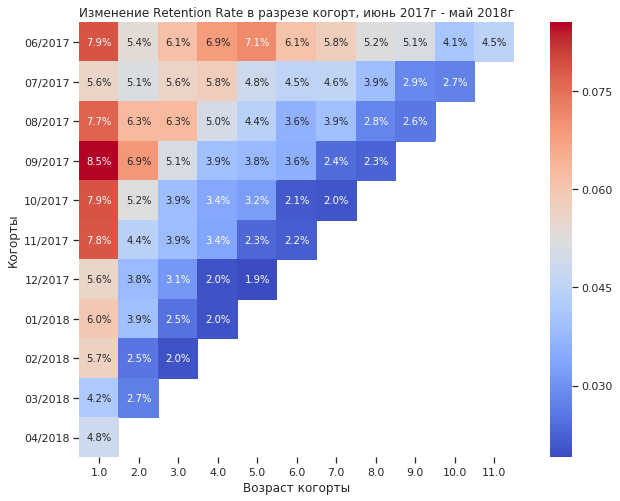

In [73]:
plt.figure(figsize=(13, 8))
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
sns.heatmap(retention_pivot, cmap= 'coolwarm', annot=True, fmt = '.1%', square=True, annot_kws={"size":10})
plt.title('Изменение Retention Rate в разрезе когорт, июнь 2017г - май 2018г')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорты')

In [74]:
print('Средний retention rate на второй месяц жизни когорт составляет {:.2%}'.format(retention_pivot[1].mean()))

Средний retention rate на второй месяц жизни когорт составляет 6.52%


Коэффициент удержания снижается у каждой следующей когорты - если у когорт в 2017г эта метрика на второй месяц жизни составляла порядка 8%, то в когортах марта и апреля 2018г. этот показатель опустился ниже 5%.

Когорта 06-2017 показывает наилучшие результаты по удержанию пользователей в сравнении в остальными когортами анализируемого периода. К концу 11 месяца жизни когорты метрика составила 4,5%, тогда как в когорте 03-2018 этот показатель уже на 2 месяц был ниже и составлял 4,2%.

Когорты 08-2017 и 09-2017 показывали хорошую величину retention rate на первых месяцах жизни когорты, но после 4 периода метрика резко снизилась и продолжает снижаться с течением времени. Возможно, пользователям в этих когортах нужен стимул, чтобы вернуться к более высокому показателю retention rate.

<a id='e-commerce'></a>
### Шаг 3.2 Метрики электронной коммерции

<a id='delta'></a>
#### Шаг 3.2.1 Время до совершения покупки

Сравним время первого посещения Яндекс.Афиши и время совершения покупки

In [75]:
orders_log = orders_log.merge(first_activity_date, on='uid')

In [76]:
orders_log['time_to_purchase'] = (orders_log['buy_ts'] - orders_log['first_activity_date']).dt.days

Text(0, 0.5, 'Количество пользователей, шт.')

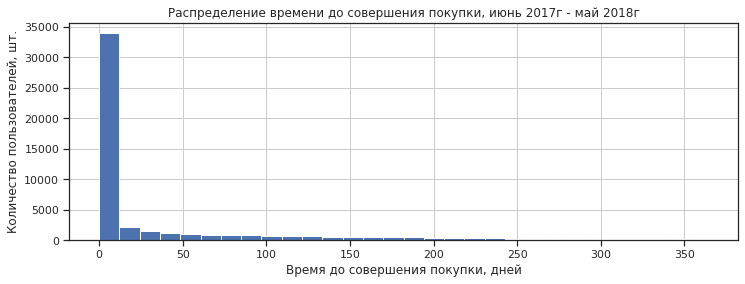

In [77]:
orders_log['time_to_purchase'].hist(bins=30, figsize=(12, 4))
plt.title('Распределение времени до совершения покупки, июнь 2017г - май 2018г')
plt.xlabel('Время до совершения покупки, дней')
plt.ylabel('Количество пользователей, шт.')

In [78]:
orders_log['time_to_purchase'].describe()

count   50414.00
mean       36.79
std        70.49
min         0.00
25%         0.00
50%         0.00
75%        38.00
max       364.00
Name: time_to_purchase, dtype: float64

Распределение времени до совершения покупки не является нормальным, но наглядно показывает, что средний клиент делает покупку в тот же день, когда был совершен первый вход на сайт

<a id='avg_buys'></a>
#### Шаг 3.2.2 Среднее количество покупок на одного покупателя

In [79]:
orders_log.groupby('uid')['buy_ts'].count().describe()

count   36522.00
mean        1.38
std         3.45
min         1.00
25%         1.00
50%         1.00
75%         1.00
max       239.00
Name: buy_ts, dtype: float64

Как уже было указано, на одного покупателя в год приходится в среднем 1.38 заказа. Есть и те, кто совершал покупку каждые 1,5 дня, но не всем быть театральными или кино-критиками, типичный пользователь совершает ровно одну покупку в год и видимо считает это вполне достаточным для жизненного тонуса, культурного обогащения или обогащения своей любимой музыкальной группы.

In [80]:
n_orders_by_months = orders_log.groupby('order_month')['buy_ts'].count().reset_index()
n_orders_by_months.columns = ['order_month', 'n_orders']

Рассчитаем накопительно сумму заказов, совершенные за каждые 6 месяцев анализируемого периода

In [81]:
n_orders_by_months['sum_orders'] = n_orders_by_months.rolling(6).sum()

In [82]:
n_orders_by_months

,order_month,n_orders,sum_orders
0,2017-06-01,2354,nan
1,2017-07-01,2363,nan
2,2017-08-01,1807,nan
3,2017-09-01,3387,nan
4,2017-10-01,5679,nan
5,2017-11-01,5659,21249.00
6,2017-12-01,6218,25113.00
7,2018-01-01,4721,27471.00
8,2018-02-01,5281,30945.00
9,2018-03-01,5326,32884.00


In [83]:
n_customers_by_months = orders_log.groupby('order_month')['uid'].nunique().reset_index()
n_customers_by_months.columns = ['order_month', 'n_customers']

Аналогично поступим с количеством покупателей и найдем их суммарное значение за каждые 6 месяцев

In [84]:
n_customers_by_months['sum_customers'] = n_customers_by_months.rolling(6).sum()

In [85]:
n_customers_by_months

,order_month,n_customers,sum_customers
0,2017-06-01,2023,nan
1,2017-07-01,1984,nan
2,2017-08-01,1472,nan
3,2017-09-01,2750,nan
4,2017-10-01,4675,nan
5,2017-11-01,4547,17451.00
6,2017-12-01,4942,20370.00
7,2018-01-01,3898,22284.00
8,2018-02-01,4258,25070.00
9,2018-03-01,4181,26501.00


In [86]:
avg_orders = pd.merge(n_orders_by_months, n_customers_by_months, on='order_month')

In [87]:
avg_orders['avg_orders_per_customer'] = avg_orders['sum_orders'] / avg_orders['sum_customers']

In [88]:
avg_orders

,order_month,n_orders,sum_orders,n_customers,sum_customers,avg_orders_per_customer
0,2017-06-01,2354,nan,2023,nan,nan
1,2017-07-01,2363,nan,1984,nan,nan
2,2017-08-01,1807,nan,1472,nan,nan
3,2017-09-01,3387,nan,2750,nan,nan
4,2017-10-01,5679,nan,4675,nan,nan
5,2017-11-01,5659,21249.00,4547,17451.00,1.22
6,2017-12-01,6218,25113.00,4942,20370.00,1.23
7,2018-01-01,4721,27471.00,3898,22284.00,1.23
8,2018-02-01,5281,30945.00,4258,25070.00,1.23
9,2018-03-01,5326,32884.00,4181,26501.00,1.24


In [89]:
print('В среднем на каждого покупателя приходится {:.2f} заказов за 6 месяцев'.
      format(avg_orders['avg_orders_per_customer'].mean()))

В среднем на каждого покупателя приходится 1.23 заказов за 6 месяцев


<a id='avg_check'></a>
#### Шаг 3.2.3 Средний чек

In [90]:
print('Средняя стоимость одного заказа {:.2f} у.е.'.format(orders_log['revenue'].sum() / len(orders_log)))

Средняя стоимость одного заказа 5.00 у.е.


Посмотрим как меняется средний чек на один заказ в анализируемом периоде

In [91]:
revenue_mean = orders_log.groupby('order_month')['revenue'].mean()
revenue_mean

order_month
2017-06-01   4.06
2017-07-01   5.31
2017-08-01   4.85
2017-09-01   5.42
2017-10-01   4.93
2017-11-01   4.78
2017-12-01   5.85
2018-01-01   4.11
2018-02-01   4.84
2018-03-01   5.41
2018-04-01   5.15
2018-05-01   4.77
Name: revenue, dtype: float64

Text(0, 0.5, 'Средний чек на заказ, у.е.')

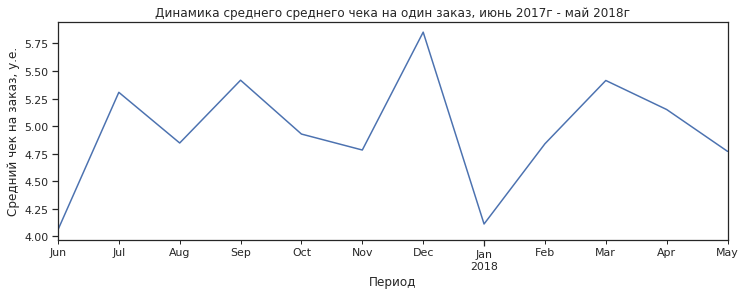

In [92]:
revenue_mean.plot(figsize=(12,4))
plt.title('Динамика среднего среднего чека на один заказ, июнь 2017г - май 2018г')
plt.xlabel('Период')
plt.ylabel('Средний чек на заказ, у.е.')

Наименьшие значения среднего чека на заказ наблюдаются в июне и январе, а максимальный в декабре - период новогодних праздников хорош не только для увеличения количества заказов, но и для того, чтобы клиенты покупали билеты на более дорогостоящие мероприятия.

Вообще пики повышения среднего чека на заказ видны каждый квартал (июль, сентябрь, декабрь, март). Возможно, это связано с гастролями популярных артистов, где цена билетов на концерты является фактором, влияющим на повышение сренего чека. С другой стороны это может быть связано с финансовыми возможностями покупателей, которые склонны купить более дорогой билет при появлении возможности, например, с квартальной премии покупают билет в первый ряд вместо балкона.

Рассмотрим этот же показатель, но в расчете на одного покупателя

In [93]:
sum_revenue = orders_log.groupby('order_month')['revenue'].sum().reset_index()

In [94]:
avg_order_value = pd.merge(n_customers_by_months, sum_revenue, on='order_month')
avg_order_value.drop(columns=['sum_customers'], inplace=True)
avg_order_value['order_value'] = avg_order_value['revenue'] / avg_order_value['n_customers']

In [95]:
avg_order_value

,order_month,n_customers,revenue,order_value
0,2017-06-01,2023,9557.49,4.72
1,2017-07-01,1984,12539.47,6.32
2,2017-08-01,1472,8758.78,5.95
3,2017-09-01,2750,18345.51,6.67
4,2017-10-01,4675,27987.70,5.99
5,2017-11-01,4547,27069.93,5.95
6,2017-12-01,4942,36388.60,7.36
7,2018-01-01,3898,19417.13,4.98
8,2018-02-01,4258,25560.54,6.00
9,2018-03-01,4181,28834.59,6.90


Text(0, 0.5, 'Средний чек на покупателя, у.е.')

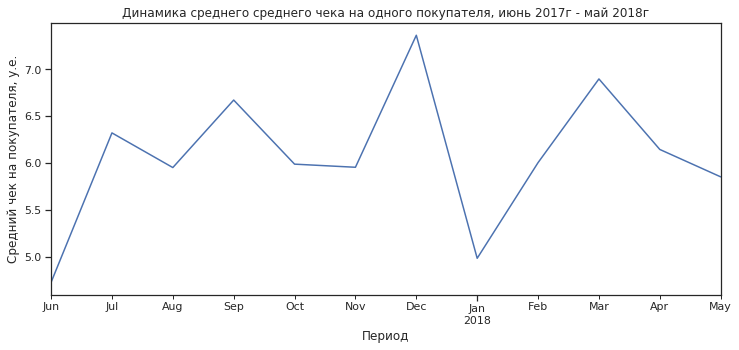

In [96]:
fig, ax = plt.subplots(figsize=(12,4))
avg_order_value[['order_month', 'order_value']].set_index('order_month').plot(figsize=(12,5), ax=ax)
ax.get_legend().remove()
plt.title('Динамика среднего среднего чека на одного покупателя, июнь 2017г - май 2018г')
plt.xlabel('Период')
plt.ylabel('Средний чек на покупателя, у.е.')

Средний чек на одного покупателя ведет себя схожим образом со средним чеком на заказ - мы также видим пики каждый квартал и также видим провалы в июне и в январе. Понятно, что раз на одного покупателя в среднем приходится не ровно 1 заказ, а несколько больше, то и стоимость среднего чека на покупателя выше аналогичного показателя в расчете на заказ.

<a id='ltv'></a>
#### Шаг 3.2.4 LTV

Посмотрим, сколько составляет LTV на покупателя и как меняется этот показатель по когортам

In [97]:
cohorts_ltv = orders_log.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

In [98]:
cohort_sizes = orders_log.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [99]:
cohorts_ltv = cohorts_ltv.merge(cohort_sizes, on='first_order_month')

Поскольку маржинальность составляет 100%, то валовая прибыль в данном случае будет равна выручке

In [100]:
cohorts_ltv['lifetime'] = (cohorts_ltv['order_month'] - cohorts_ltv['first_order_month']) / np.timedelta64(1, 'M')
cohorts_ltv['lifetime'] = cohorts_ltv['lifetime'].round().astype('int')

In [101]:
cohorts_ltv['ltv'] = cohorts_ltv['revenue'] / cohorts_ltv['n_buyers']

In [102]:
ltv_cohorts = cohorts_ltv.pivot_table(index='first_order_month', columns='lifetime', values='ltv', aggfunc='mean')

Text(238.94000000000005, 0.5, 'Когорты')

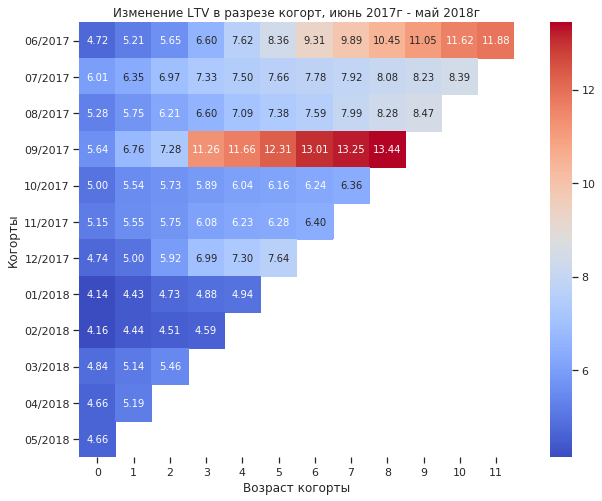

In [103]:
plt.figure(figsize=(13, 8))
ltv_cohorts.index = ltv_cohorts.index.strftime("%m/%Y")
sns.heatmap(ltv_cohorts.cumsum(axis=1), cmap= 'coolwarm', annot=True, fmt = '.2f', square=True, annot_kws={"size":10})
plt.title('Изменение LTV в разрезе когорт, июнь 2017г - май 2018г')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорты')

 Посмотрим средний LTV за 6 месяцев по когортам, срок жизни которых составляет не менее 6 месяцев

In [104]:
cohorts_6_m = cohorts_ltv[(cohorts_ltv['first_order_month'] < '2018-01-01') & (cohorts_ltv['lifetime'] < 6)]

In [105]:
ltv_6_m = cohorts_6_m.groupby('first_order_month').agg({'revenue' : 'sum', 'n_buyers' : 'mean'})
ltv_6_m['ltv'] = ltv_6_m['revenue'] / ltv_6_m['n_buyers']

In [106]:
print('Средний LTV между когортами, живущими минимум 6 месяцев: {} у.е.'.format(round(ltv_6_m['ltv'].mean(), 2)))

Средний LTV между когортами, живущими минимум 6 месяцев: 7.97 у.е.


Text(0, 0.5, 'Средний LTV, у.е. на 1 участника когорты')

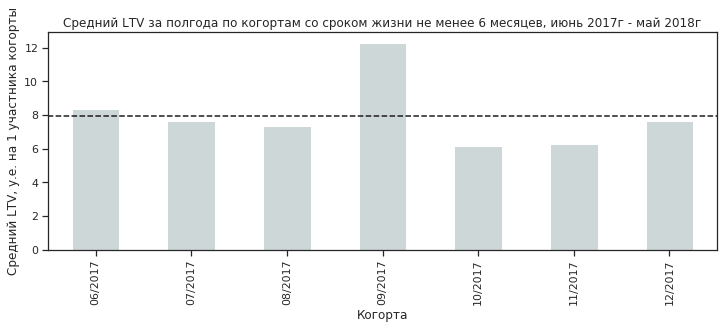

In [107]:
ltv_6_m.index = ltv_6_m.index.strftime("%m/%Y")
ltv_6_m['ltv'].plot(kind='bar', figsize=(12,4), color='#ced7d8')
plt.hlines(ltv_6_m['ltv'].mean(), -1, 7, linestyles='dashed')
plt.title('Средний LTV за полгода по когортам со сроком жизни не менее 6 месяцев, июнь 2017г - май 2018г')
plt.xlabel('Когорта')
plt.ylabel('Средний LTV, у.е. на 1 участника когорты')

In [108]:
cohorts_6_m.pivot_table(index='first_order_month', columns='lifetime', values='ltv', aggfunc='sum', margins=True)

lifetime,0,1,2,3,4,5,All
first_order_month,,,,,,,
2017-06-01 00:00:00,4.72,0.49,0.44,0.95,1.02,0.74,8.36
2017-07-01 00:00:00,6.01,0.34,0.62,0.36,0.18,0.16,7.66
2017-08-01 00:00:00,5.28,0.47,0.46,0.39,0.49,0.28,7.38
2017-09-01 00:00:00,5.64,1.12,0.52,3.98,0.40,0.65,12.31
2017-10-01 00:00:00,5.00,0.54,0.19,0.16,0.15,0.12,6.16
2017-11-01 00:00:00,5.15,0.40,0.20,0.32,0.15,0.05,6.28
2017-12-01 00:00:00,4.74,0.26,0.93,1.07,0.31,0.34,7.64
All,36.55,3.61,3.36,7.23,2.71,2.33,55.78


Наибольший доход на 1 участника когорты приносит когорта 09-2017 (12,31 у.е. на 1 участника когорты) - ее LTV был вторым по величине в нулевой период среди всех когорт (5,64 у.е.), но на 4 месяц существования эта когорта снова принесла 3,98 у.е. на 1 участника, что и позволило ей оказаться в лидерах. 4 месяц в данной когорте пришелся на декабрь, и именно эта когорта внесла значительный вклад в выскоие продажи декабря.

Вторым результатом LTV за полугодовой период стало 8,36 у.е. на 1 участника когорты 06-2017. За первый месяц ее LTV было самым низким среди выделенных когорт, но на 4, 5 и 6 месяц когорта показывала LTV от 0,7 до 1 у.е. на участника, такая стабильность позволила выйти в лидеры по данной метрике.

3 когорты (07-2017, 08-2017 и 12/2017) показали накопленный за полгода LTV в размере 7,4...7,7 у.е. на участника когорты. В этих когортах основной вклад в суммарный LTV был заложен в первом месяце существования когорты.

Аналогичный принцип по формированию итогового LTV наблюдается у когорт 10-2017 и 11-2017 в накоптельным LTV в размере 6,2...6,3 у.е. на участника когорты. 

<a id='marketing'></a>
### Шаг 3.3 Маркетинговые метрики

Посмотрим в целом на маркетинговые расходы

In [109]:
costs_by_months = costs.groupby('dt_month')['costs'].sum().reset_index()
costs_by_months['part_of_year_costs'] = costs_by_months['costs'] / costs_by_months['costs'].sum()
costs_by_months

,dt_month,costs,part_of_year_costs
0,2017-06-01,18015.00,0.05
1,2017-07-01,18240.59,0.06
2,2017-08-01,14790.54,0.04
3,2017-09-01,24368.91,0.07
4,2017-10-01,36322.88,0.11
5,2017-11-01,37907.88,0.12
6,2017-12-01,38315.35,0.12
7,2018-01-01,33518.52,0.10
8,2018-02-01,32723.03,0.10
9,2018-03-01,30415.27,0.09


Text(0, 0.5, 'Месячные маркетинговые расходы, у.е.')

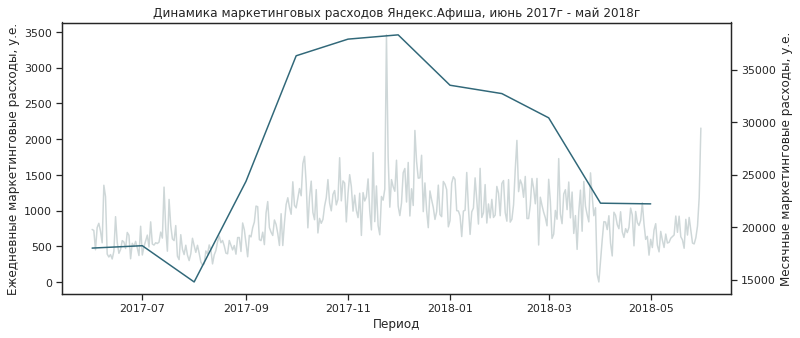

In [110]:
data_1 = costs.groupby('dt')['costs'].sum()
data_2 = costs_by_months.groupby('dt_month')['costs'].sum()
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
sns.lineplot(data=data_1, ci=None, ax=ax, color='#ced7d8')
sns.lineplot(data=data_2, ci=None, ax=ax2, color='#316879')
plt.title('Динамика маркетинговых расходов Яндекс.Афиша, июнь 2017г - май 2018г')
ax.set_xlabel('Период')
ax.set_ylabel('Ежедневные маркетинговые расходы, у.е.')
ax2.set_ylabel('Месячные маркетинговые расходы, у.е.')

Затраты на маркетинг в абсолютном выражении не равномерны в течение года - наибольший объем инвестиций в макретинг происходит в период перед новогодними праздниками - это вполне логично, в этот период мы видели пик продаж и по объему, и по средней стоимости заказа. Наименьшие суммы маркетинговых расходов наблюдаются в период с апреля по август, что также выглядит адекватно, учитывая сезонность спроса.

<a id='marketing_costs'></a>
#### Шаг 3.3.1 Расходы на маркетинг

Посмотрим распределение маркетинговых затрат по источникам трафика

In [111]:
costs_by_source = costs.groupby('source_id').agg({'source_id': 'count', 'costs' : 'sum'})
costs_by_source.columns = ['count', 'sum_costs']
costs_by_source['part_of_total_costs'] = costs_by_source['sum_costs'] / costs_by_source['sum_costs'].sum()
costs_by_source['costs_per_unit'] = costs_by_source['sum_costs'] / costs_by_source['count']
costs_by_source.reset_index()

,source_id,count,sum_costs,part_of_total_costs,costs_per_unit
0,1,363,20833.27,0.06,57.39
1,2,363,42806.04,0.13,117.92
2,3,363,141321.63,0.43,389.32
3,4,363,61073.60,0.19,168.25
4,5,364,51757.10,0.16,142.19
5,9,363,5517.49,0.02,15.20
6,10,363,5822.49,0.02,16.04


Text(0, 0.5, 'Затраты, у.е.')

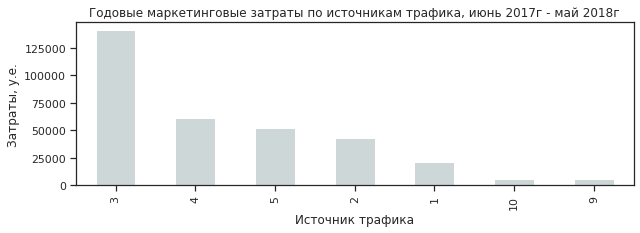

In [112]:
costs_by_source['sum_costs'].sort_values(ascending=False).plot(kind='bar', figsize=(10,3), color='#ced7d8')
plt.title('Годовые маркетинговые затраты по источникам трафика, июнь 2017г - май 2018г')
plt.xlabel('Источник трафика')
plt.ylabel('Затраты, у.е.')

Почти половину от всех затрат на маркетинг составляют инвестиции в канал №3 (43% от всех маркетинговых затрат или 140 тыс.у.е. за год). Затраты в каналы №4, 5 и 2 отличаются друг от друга не столько значительно (~40-60 тыс.у.е. в год), суммарно они занимают 48% маркетингового бюджета. Каналы №1, 10 и 9 наименее затратны, их доля в бюджете суммарно занимает около 10%.

Проанализируем структуру ежемесячных маркетинговых расходов в разрезе источников трафика.

In [113]:
costs_pivot = costs.pivot_table(index='dt_month', columns='source_id', values='costs', aggfunc='sum')
costs_pivot

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


In [114]:
costs.pivot_table(index='dt_month', columns='source_id', values='costs', aggfunc='count')

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06-01,30,30,30,30,30,30,30
2017-07-01,31,31,31,31,31,31,31
2017-08-01,31,31,31,31,31,31,31
2017-09-01,30,30,30,30,30,30,30
2017-10-01,31,31,31,31,31,31,31
2017-11-01,30,30,30,30,30,30,30
2017-12-01,31,31,31,31,31,31,31
2018-01-01,31,31,31,31,31,31,31
2018-02-01,28,28,28,28,28,28,28


Количество переходов из каждого источника каждый период одинакова, значит, можем смотреть абсолютные значения в динамике, они покажут ту же картину, как если бы мы смотрели относительную стоимость перехода по каждому источнику

Text(0, 0.5, 'Затраты, у.е.')

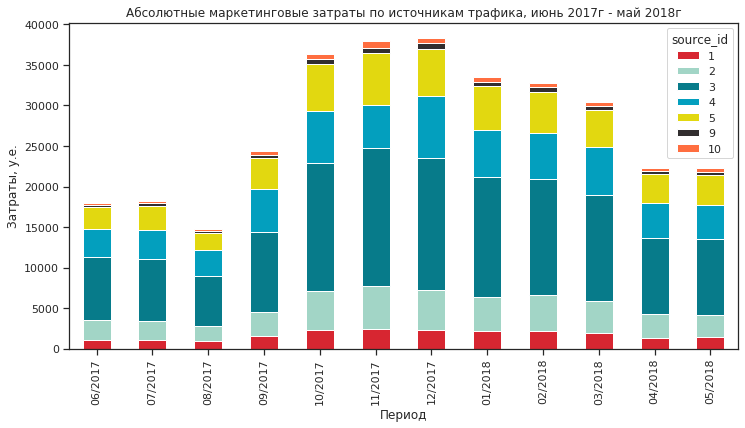

In [115]:
costs_pivot.index = costs_pivot.index.strftime("%m/%Y")
costs_pivot.plot(kind='bar', stacked=True, figsize=(12,6), color=['#d72631', '#a2d5c6', '#077b8a', '#039fbe', '#e2d810', '#322e2f', '#ff6e40'])
plt.title("Абсолютные маркетинговые затраты по источникам трафика, июнь 2017г - май 2018г")
plt.xlabel("Период")
plt.ylabel("Затраты, у.е.")

Рассчитаем нормированные затраты, чтобы изучить структуру затрат в разрезе источников трафика по периодам

In [116]:
percent_costs_pivot = pd.DataFrame()
for col in costs_pivot.T.columns:
    percent_costs_pivot[str(col)] = costs_pivot.T[col] / costs_pivot.T[col].sum()
percent_costs_pivot

,06/2017,07/2017,08/2017,09/2017,10/2017,11/2017,12/2017,01/2018,02/2018,03/2018,04/2018,05/2018
source_id,,,,,,,,,,,,
1,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.07,0.06,0.06,0.07
2,0.13,0.13,0.12,0.12,0.13,0.14,0.13,0.12,0.14,0.13,0.13,0.12
3,0.43,0.42,0.42,0.41,0.43,0.45,0.42,0.44,0.43,0.43,0.42,0.42
4,0.20,0.19,0.22,0.21,0.18,0.14,0.20,0.17,0.17,0.20,0.20,0.19
5,0.15,0.16,0.15,0.16,0.16,0.17,0.15,0.16,0.15,0.15,0.16,0.17
9,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
10,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.02


Text(0, 0.5, 'Доли единицы')

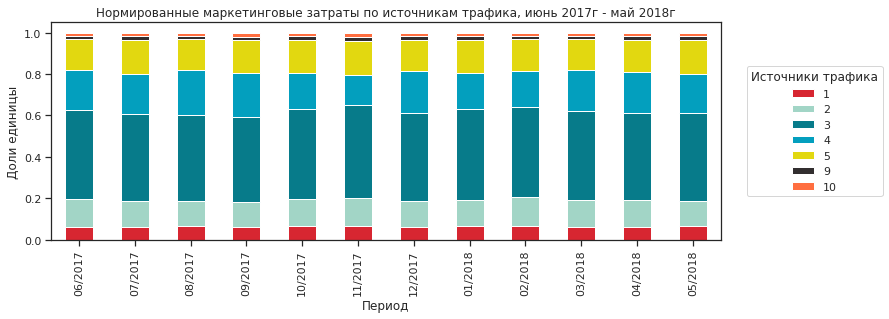

In [117]:
fig, ax = plt.subplots()
(percent_costs_pivot.T
 .plot(kind='bar', stacked=True, ax=ax,
       figsize=(12,4), color=['#d72631', '#a2d5c6', '#077b8a', '#039fbe', '#e2d810', '#322e2f', '#ff6e40']))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=5, bbox_to_anchor=(1.25,0.5), title = 'Источники трафика')
plt.title("Нормированные маркетинговые затраты по источникам трафика, июнь 2017г - май 2018г")
plt.xlabel("Период")
plt.ylabel("Доли единицы")

Наглядно видно, что ежемесячная структура маркетинговых расходов довольно стабильна и соответствует структуре затрат в целом по году - в любой из периодов расходы в источник №3 самые объемные и их доля практически неизменна по периодам (составляет от 42% до 45% всех маркетинговых затрат); затраты в источники 2,4 и 5 составляют порядка 50% бюджета периода, оставшиеся 3 источника составляют порядка 10% бюджета.

<a id='cac'></a>
#### Шаг 3.3.2 CAC

Рассчитаем метрику CAC в расчете на одного покупателя и с помощью когортного анализа в расчете на 1 участника когорты.

Чтобы найти CAC на одного покупателя для всего проекта, добавим столбец с количеством покупателей в каждом из периодов

In [118]:
value_and_costs_by_month = pd.merge(avg_order_value, costs_by_months, left_on='order_month', right_on='dt_month')
value_and_costs_by_month.drop(columns=['order_value', 'dt_month', 'part_of_year_costs'], inplace=True)
value_and_costs_by_month['cac'] = value_and_costs_by_month['costs'] / value_and_costs_by_month['n_customers']
value_and_costs_by_month

,order_month,n_customers,revenue,costs,cac
0,2017-06-01,2023,9557.49,18015.00,8.91
1,2017-07-01,1984,12539.47,18240.59,9.19
2,2017-08-01,1472,8758.78,14790.54,10.05
3,2017-09-01,2750,18345.51,24368.91,8.86
4,2017-10-01,4675,27987.70,36322.88,7.77
5,2017-11-01,4547,27069.93,37907.88,8.34
6,2017-12-01,4942,36388.60,38315.35,7.75
7,2018-01-01,3898,19417.13,33518.52,8.60
8,2018-02-01,4258,25560.54,32723.03,7.69
9,2018-03-01,4181,28834.59,30415.27,7.27


In [119]:
avg_cac = value_and_costs_by_month['costs'].sum() / orders_log['uid'].nunique()
print('Cредний CAC на одного покупателя для всего проекта составляет {:.2f} у.е.'.format(avg_cac))

Cредний CAC на одного покупателя для всего проекта составляет 9.01 у.е.


In [120]:
value_and_costs_by_month['order_month'] = value_and_costs_by_month['order_month'].dt.date

Text(0, 0.5, 'CAC, у.е.')

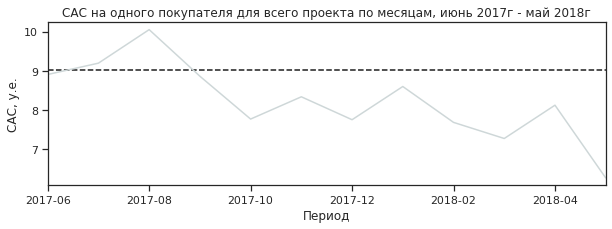

In [121]:
fig, ax = plt.subplots()
value_and_costs_by_month[['order_month', 'cac']].plot(figsize=(10,3), color='#ced7d8', ax=ax)
plt.hlines(avg_cac, 0, value_and_costs_by_month.index.max(), linestyles='dashed')
ax.set_xticklabels(['2017-06', '2017-08', '2017-10', '2017-12', '2018-02', '2018-04'])
ax.get_legend().remove()
plt.title("CAC на одного покупателя для всего проекта по месяцам, июнь 2017г - май 2018г")
plt.xlabel("Период")
plt.ylabel("CAC, у.е.")

Стоимость привлечения клиента имеет нисходящий тренд и снижается с пикового значения 10.05 у.е. на одного покупателя в августе 2017г до 6.27 у.е. в мае 2018г. Оптимизация затрат может быть позитивным фактором, если как минимум сохраняется эффективность привлечения клиентов и не снижается маржинальный доход, который они приносят.

Посмотрим стоимость привлечения покупателей в разрезе источников трафика

In [122]:
n_users_by_source_in_month = orders_by_source.groupby(['order_month', 'source_id']).agg({'uid' : 'nunique'}).reset_index()

In [123]:
costs_by_source_in_month = costs.groupby(['dt_month','source_id'])['costs'].sum().reset_index()

In [124]:
cac = pd.merge(n_users_by_source_in_month, costs_by_source_in_month, left_on = ['order_month','source_id'], right_on = ['dt_month','source_id'])
cac.drop(columns='dt_month', inplace=True)
cac['cac'] = cac['costs'] / cac['uid']

In [125]:
cac_pivot = cac.pivot_table(index='order_month', columns='source_id', values='cac')

Text(114.68857142857149, 0.5, 'Источники трафика')

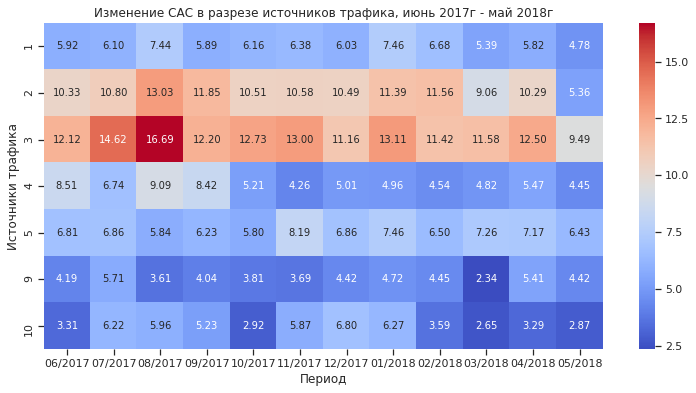

In [126]:
plt.figure(figsize=(13, 6))
cac_pivot.index = cac_pivot.index.strftime("%m/%Y")
sns.heatmap(data=cac_pivot.T, cmap= 'coolwarm', annot=True, fmt = '.2f', square=True, annot_kws={"size":10})
plt.title('Изменение CAC в разрезе источников трафика, июнь 2017г - май 2018г')
plt.xlabel('Период')
plt.ylabel('Источники трафика')

In [127]:
avg_cac_by_source = cac.groupby('source_id').agg({'costs' : 'sum', 'uid' : 'sum'})
avg_cac_by_source['avg_cac'] = avg_cac_by_source['costs'] / avg_cac_by_source['uid']
avg_cac_by_source

,costs,uid,avg_cac
source_id,,,
1,20833.27,3405,6.12
2,42806.04,4246,10.08
3,141321.63,11590,12.19
4,61073.60,11363,5.37
5,51757.10,7618,6.79
9,5517.49,1383,3.99
10,5822.49,1412,4.12


Text(0, 0.5, 'CAC, у.е.')

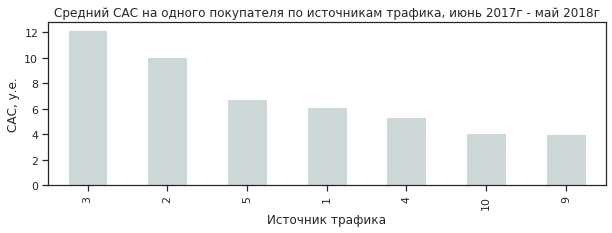

In [128]:
avg_cac_by_source['avg_cac'].sort_values(ascending=False).plot(kind='bar', figsize=(10,3), color='#ced7d8')
plt.title('Cредний CAC на одного покупателя по источникам трафика, июнь 2017г - май 2018г')
plt.xlabel('Источник трафика')
plt.ylabel('CAC, у.е.')

Наиболее затратным источником привлечения покупателей является №3, несмотря на то, что к концу анализируемого периода видим небольшое снижение метрики, затраты на привлечение клиентов в этом источнике являются максимальными почти в каждом из проанализированных месяцев и в целом за год (в среднем 12,19 у.е. на покупателя).

На втором месте источник №2, данная метрика в течение года была довольно стабильной и средняя стоимость привлечения клиентов составила 10,08 у.е. за анализируемый год. 

Эти 2 источника условно можно считать дорогими в привлечении клиентов.

Источники 5, 1 и 4 имеют средний уровень САС от 5,4 до 6,8 у.е. на покупателя и их можно выделить в группу источников со средней стоимостью привлечения клиентов.

Оставшиеся 2 источника (10 и 9) имеют средний уровень САС в районе 4 у.е. на покупателя и эту группу условно можно обозначить как дешевые источники привлечения клиентов.

Рассчитаем CAC в целом по проекту на 1 участника каждой из когорт

In [129]:
cost_by_cohorts = pd.merge(cohort_sizes, costs_by_months, left_on='first_order_month', right_on='dt_month')
cost_by_cohorts.drop(columns=['dt_month', 'part_of_year_costs'], inplace=True)
cost_by_cohorts['cac_by_cohort_member'] = cost_by_cohorts['costs'] / cost_by_cohorts['n_buyers']
cost_by_cohorts

,first_order_month,n_buyers,costs,cac_by_cohort_member
0,2017-06-01,2023,18015.00,8.91
1,2017-07-01,1923,18240.59,9.49
2,2017-08-01,1370,14790.54,10.80
3,2017-09-01,2581,24368.91,9.44
4,2017-10-01,4340,36322.88,8.37
5,2017-11-01,4081,37907.88,9.29
6,2017-12-01,4383,38315.35,8.74
7,2018-01-01,3373,33518.52,9.94
8,2018-02-01,3651,32723.03,8.96
9,2018-03-01,3533,30415.27,8.61


Text(0, 0.5, 'CAC, у.е.')

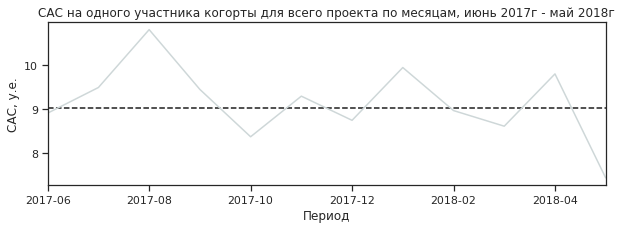

In [130]:
fig, ax = plt.subplots()
cost_by_cohorts['cac_by_cohort_member'].plot(figsize=(10,3), color='#ced7d8')
plt.hlines(avg_cac, 0, cost_by_cohorts.index.max(), linestyles='dashed')
ax.set_xticklabels(['2017-06', '2017-08', '2017-10', '2017-12', '2018-02', '2018-04'])
plt.title("CAC на одного участника когорты для всего проекта по месяцам, июнь 2017г - май 2018г")
plt.xlabel("Период")
plt.ylabel("CAC, у.е.")

В расчете на 1 участника когорты тренд на снижение CAC уже не такой явный. Наибольшая стоимость привлечения клиента наблюдается в периоды с низким спросом, а провалы соответствуют месяцам с пиковыми продажами.

Сформируем таблицы для расчета CAC на 1 участника когорты в разрезе источников трафика

In [131]:
n_cohorts_member_by_source = orders_by_source.groupby(['first_order_month', 'source_id']).agg({'uid' : 'nunique'}).reset_index()

In [132]:
cac_by_cohorts = pd.merge(n_cohorts_member_by_source, costs_by_source_in_month, left_on = ['first_order_month','source_id'], right_on = ['dt_month','source_id'])
cac_by_cohorts.drop(columns='dt_month', inplace=True)
cac_by_cohorts = cac_by_cohorts.rename(columns={'uid' : 'n_cohorts_member'})
cac_by_cohorts['cac_by_cohort_member'] = cac_by_cohorts['costs'] / cac_by_cohorts['n_cohorts_member']
cac_by_cohorts.head()

,first_order_month,source_id,n_cohorts_member,costs,cac_by_cohort_member
0,2017-06-01,1,190,1125.61,5.92
1,2017-06-01,2,235,2427.38,10.33
2,2017-06-01,3,638,7731.65,12.12
3,2017-06-01,4,413,3514.80,8.51
4,2017-06-01,5,384,2616.12,6.81


In [133]:
cac_by_cohorts_pivot = cac_by_cohorts.pivot_table(index='first_order_month', columns='source_id', values='cac_by_cohort_member', aggfunc='sum')

Text(114.68857142857149, 0.5, 'Источники трафика')

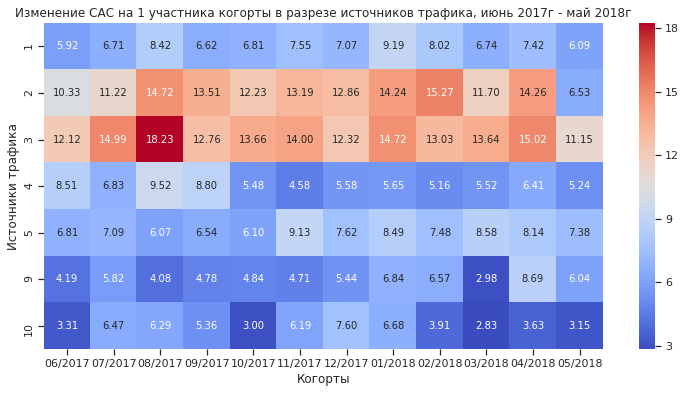

In [134]:
plt.figure(figsize=(13, 6))
cac_by_cohorts_pivot.index = cac_by_cohorts_pivot.index.strftime("%m/%Y")
sns.heatmap(data=cac_by_cohorts_pivot.T, cmap= 'coolwarm', annot=True, fmt = '.2f', square=True, annot_kws={"size":10})
plt.title('Изменение CAC на 1 участника когорты в разрезе источников трафика, июнь 2017г - май 2018г')
plt.xlabel('Когорты')
plt.ylabel('Источники трафика')

In [135]:
avg_cac_by_cohorts_on_source = cac_by_cohorts.groupby('source_id').agg({'costs' : 'sum', 'n_cohorts_member' : 'sum'})
avg_cac_by_cohorts_on_source['avg_cac_by_cohort'] = avg_cac_by_cohorts_on_source['costs'] / avg_cac_by_cohorts_on_source['n_cohorts_member']
avg_cac_by_cohorts_on_source

,costs,n_cohorts_member,avg_cac_by_cohort
source_id,,,
1,20833.27,2899,7.19
2,42806.04,3506,12.21
3,141321.63,10473,13.49
4,61073.60,10295,5.93
5,51757.10,6931,7.47
9,5517.49,1088,5.07
10,5822.49,1329,4.38


Text(0, 0.5, 'CAC, у.е.')

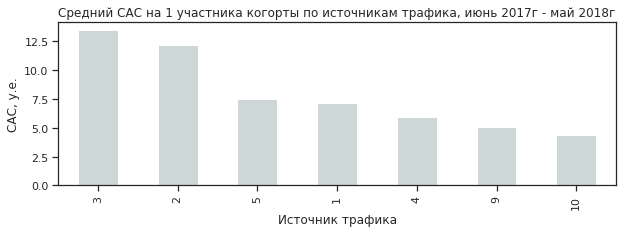

In [136]:
avg_cac_by_cohorts_on_source['avg_cac_by_cohort'].sort_values(ascending=False).plot(kind='bar', figsize=(10,3), color='#ced7d8')
plt.title('Cредний CAC на 1 участника когорты по источникам трафика, июнь 2017г - май 2018г')
plt.xlabel('Источник трафика')
plt.ylabel('CAC, у.е.')

Картинка получилась весьма похожей на разброс значений среднего CAC по источникам трафика, но в расечете на 1 покупателя. По условно выделенным группам попадают те же источники. Небольшие отличия:
- по источнику №3 тенденция к снижению метрики не такая явная,
- отрыв между первым и вторым местом по величине затрат на привлечение клиентов меньше,
- минимальный САС на 1 участника когорты наблюдается по источнику №10, а не №9 как в случае с САС на 1 покупателя.

Но чтобы понять, насколько каждый из источников эффективен в привлечении клиентов, посчитаем рентабельность  инвестиций в маркетинговую деятельность.

<a id='romi'></a>
#### Шаг 3.3.3 ROMI

Рассчитаем ROMI по когортам в целом и в разрезе источников трафика

In [137]:
orders_by_source_in_month = orders_by_source.groupby(['first_order_month', 'source_id', 'cohort_lifetime']).agg({'revenue' : 'sum'}).reset_index()

In [138]:
romi = pd.merge(orders_by_source_in_month, cac_by_cohorts, 
                left_on = ['first_order_month','source_id'], right_on = ['first_order_month','source_id'])
romi['ltv'] = romi['revenue'] / romi['n_cohorts_member']
romi['romi'] = romi['ltv'] / romi['cac_by_cohort_member']
romi.head()

,first_order_month,source_id,cohort_lifetime,revenue,n_cohorts_member,costs,cac_by_cohort_member,ltv,romi
0,2017-06-01,1,0.00,1378.70,190,1125.61,5.92,7.26,1.22
1,2017-06-01,1,1.00,414.98,190,1125.61,5.92,2.18,0.37
2,2017-06-01,1,2.00,419.43,190,1125.61,5.92,2.21,0.37
3,2017-06-01,1,3.00,714.24,190,1125.61,5.92,3.76,0.63
4,2017-06-01,1,4.00,811.20,190,1125.61,5.92,4.27,0.72


In [139]:
for source in [1, 2, 3, 4, 5, 9, 10]:
    output = romi[romi['source_id'] == source].pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean'
)
    display('ROMI по когортам, источник №{}'.format(source))
    display(output.cumsum(axis=1).round(2).fillna(''))
    display(output.cumsum(axis=1).mean(axis=0))

'ROMI по когортам, источник №1'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_order_month,,,,,,,,,,,,
2017-06-01,1.22,1.59,1.97,2.60,3.32,3.67,4.10,4.53,4.91,5.19,5.40,5.68
2017-07-01,1.09,1.25,2.05,2.27,2.41,2.54,2.61,2.70,2.83,2.98,3.12,
2017-08-01,0.89,1.03,1.15,1.27,1.39,1.47,1.55,1.86,2.13,2.22,,
2017-09-01,0.91,1.18,1.27,1.41,1.41,1.43,1.44,1.49,1.57,,,
2017-10-01,0.88,1.04,1.07,1.13,1.14,1.16,1.18,1.23,,,,
2017-11-01,0.98,1.06,1.18,1.30,1.32,1.34,1.35,,,,,
2017-12-01,0.65,0.69,0.73,0.77,0.77,0.78,,,,,,
2018-01-01,0.63,0.64,0.65,0.76,0.76,,,,,,,
2018-02-01,0.58,0.71,0.72,0.76,,,,,,,,


cohort_lifetime
0.00    0.89
1.00    1.05
2.00    1.26
3.00    1.36
4.00    1.57
5.00    1.77
6.00    2.04
7.00    2.36
8.00    2.86
9.00    3.46
10.00   4.26
11.00   5.68
dtype: float64

'ROMI по когортам, источник №2'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_order_month,,,,,,,,,,,,
2017-06-01,0.43,0.48,0.50,0.69,0.85,0.94,1.10,1.24,1.37,1.44,1.57,1.61
2017-07-01,0.75,0.82,0.83,0.85,0.89,0.91,0.94,0.95,0.96,0.98,1.01,
2017-08-01,0.39,0.45,0.47,0.48,0.52,0.52,0.53,0.56,0.56,0.56,,
2017-09-01,0.61,1.21,1.39,1.46,1.56,1.63,1.88,1.94,1.98,,,
2017-10-01,0.63,0.83,0.88,0.93,0.97,0.99,1.00,1.02,,,,
2017-11-01,0.53,0.60,0.63,0.69,0.72,0.73,0.74,,,,,
2017-12-01,0.69,0.81,1.53,2.39,2.63,2.88,,,,,,
2018-01-01,0.31,0.38,0.50,0.52,0.54,,,,,,,
2018-02-01,0.35,0.40,0.42,0.44,,,,,,,,


cohort_lifetime
0.00    0.55
1.00    0.63
2.00    0.78
3.00    0.94
4.00    1.09
5.00    1.23
6.00    1.03
7.00    1.14
8.00    1.22
9.00    0.99
10.00   1.29
11.00   1.61
dtype: float64

'ROMI по когортам, источник №3'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_order_month,,,,,,,,,,,,
2017-06-01,0.36,0.37,0.39,0.41,0.43,0.44,0.45,0.46,0.46,0.47,0.47,0.47
2017-07-01,0.41,0.42,0.43,0.46,0.46,0.47,0.47,0.48,0.48,0.49,0.49,
2017-08-01,0.28,0.29,0.30,0.31,0.32,0.32,0.32,0.33,0.33,0.34,,
2017-09-01,0.44,0.46,0.48,0.49,0.51,0.51,0.52,0.53,0.54,,,
2017-10-01,0.35,0.38,0.39,0.40,0.41,0.41,0.41,0.42,,,,
2017-11-01,0.32,0.33,0.34,0.35,0.35,0.35,0.36,,,,,
2017-12-01,0.34,0.35,0.36,0.37,0.38,0.38,,,,,,
2018-01-01,0.28,0.29,0.30,0.31,0.31,,,,,,,
2018-02-01,0.29,0.31,0.32,0.33,,,,,,,,


cohort_lifetime
0.00    0.34
1.00    0.36
2.00    0.37
3.00    0.38
4.00    0.39
5.00    0.41
6.00    0.42
7.00    0.44
8.00    0.45
9.00    0.43
10.00   0.48
11.00   0.47
dtype: float64

'ROMI по когортам, источник №4'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_order_month,,,,,,,,,,,,
2017-06-01,0.56,0.56,0.58,0.64,0.77,0.95,1.11,1.14,1.17,1.26,1.41,1.42
2017-07-01,0.81,0.82,0.83,0.86,0.86,0.87,0.89,0.89,0.91,0.92,0.92,
2017-08-01,0.53,0.55,0.56,0.59,0.61,0.63,0.64,0.66,0.67,0.68,,
2017-09-01,0.54,0.60,0.63,0.66,0.67,0.70,0.84,0.87,0.88,,,
2017-10-01,0.80,0.82,0.85,0.87,0.89,0.91,0.93,0.94,,,,
2017-11-01,1.12,1.26,1.29,1.38,1.42,1.43,1.48,,,,,
2017-12-01,0.75,0.76,0.78,0.80,0.80,0.82,,,,,,
2018-01-01,0.67,0.69,0.71,0.72,0.72,,,,,,,
2018-02-01,0.79,0.81,0.82,0.82,,,,,,,,


cohort_lifetime
0.00    0.76
1.00    0.78
2.00    0.79
3.00    0.81
4.00    0.84
5.00    0.90
6.00    0.98
7.00    0.90
8.00    0.90
9.00    0.95
10.00   1.17
11.00   1.42
dtype: float64

'ROMI по когортам, источник №5'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_order_month,,,,,,,,,,,,
2017-06-01,0.73,0.86,0.92,1.05,1.15,1.19,1.33,1.41,1.49,1.63,1.66,1.67
2017-07-01,0.75,0.79,0.86,0.88,0.89,0.91,0.91,0.92,0.94,0.95,0.96,
2017-08-01,0.83,0.96,1.09,1.21,1.39,1.49,1.55,1.59,1.63,1.67,,
2017-09-01,0.95,0.98,1.03,3.50,3.62,3.93,3.97,4.00,4.00,,,
2017-10-01,0.83,0.87,0.89,0.91,0.93,0.95,0.97,0.99,,,,
2017-11-01,0.50,0.52,0.53,0.54,0.55,0.56,0.57,,,,,
2017-12-01,0.66,0.68,0.69,0.69,0.70,0.70,,,,,,
2018-01-01,0.51,0.57,0.62,0.62,0.63,,,,,,,
2018-02-01,0.58,0.59,0.60,0.60,,,,,,,,


cohort_lifetime
0.00    0.66
1.00    0.72
2.00    0.78
3.00    1.11
4.00    1.23
5.00    1.39
6.00    1.55
7.00    1.78
8.00    2.02
9.00    1.42
10.00   1.31
11.00   1.67
dtype: float64

'ROMI по когортам, источник №9'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
first_order_month,,,,,,,,,,,
2017-06-01,0.85,0.87,1.01,1.15,1.22,1.32,1.45,1.48,1.61,1.64,1.66
2017-07-01,0.77,0.80,0.90,0.99,1.05,1.06,1.11,1.12,1.19,1.20,1.21
2017-08-01,1.00,1.05,1.20,1.26,1.27,1.29,1.32,1.40,1.42,1.45,
2017-09-01,0.90,1.11,1.25,1.41,1.54,1.57,1.69,1.83,2.02,,
2017-10-01,1.05,1.16,1.25,1.27,1.33,1.44,1.45,1.45,,,
2017-11-01,0.79,0.82,0.86,0.92,0.95,0.96,0.96,,,,
2017-12-01,0.70,0.76,0.79,0.84,0.85,0.87,,,,,
2018-01-01,0.41,0.45,0.48,0.48,0.48,,,,,,
2018-02-01,0.73,0.76,0.77,,,,,,,,


cohort_lifetime
0.00    0.77
1.00    0.85
2.00    0.94
3.00    1.04
4.00    1.09
5.00    1.22
6.00    1.33
7.00    1.46
8.00    1.56
9.00    1.43
10.00   1.43
dtype: float64

'ROMI по когортам, источник №10'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00
first_order_month,,,,,,,,,,
2017-06-01,0.73,0.77,,,,,,,0.77,
2017-07-01,0.54,0.54,,0.56,,,,,0.56,
2017-08-01,0.80,0.81,0.87,,,,,0.89,,0.90
2017-09-01,0.42,0.43,0.44,0.48,0.49,,,0.49,0.49,
2017-10-01,0.87,0.90,0.90,0.91,0.92,0.93,0.93,0.95,,
2017-11-01,0.75,0.76,0.76,0.79,0.80,0.81,0.82,,,
2017-12-01,0.50,0.52,,,,0.52,,,,
2018-01-01,0.46,0.47,0.48,,,,,,,
2018-02-01,0.63,0.66,0.66,,,,,,,


cohort_lifetime
0.00   0.73
1.00   0.71
2.00   0.77
3.00   0.69
4.00   0.74
5.00   0.75
6.00   0.88
7.00   0.77
8.00   0.61
9.00   0.90
dtype: float64

Когорты в разрезе источников трафика окупаются в разных периодах:
* 1 источник окупается в среднем на 2 месяц жизни когорты
* 5 и 9 источники окупается в среднем на 4 месяц жизни когорты
* 2 источник окупается в среднем на 5 месяц жизни когорты
* 4 источник окупается в среднем на 11 месяц жизни когорты
* 3 и 10 источники не окупаются

Посмотрим ROMI по когортам в разрезе источников трафика

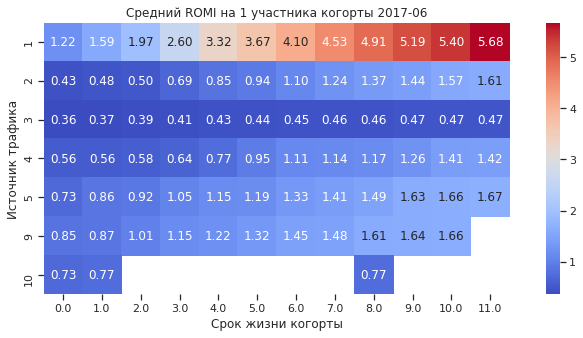

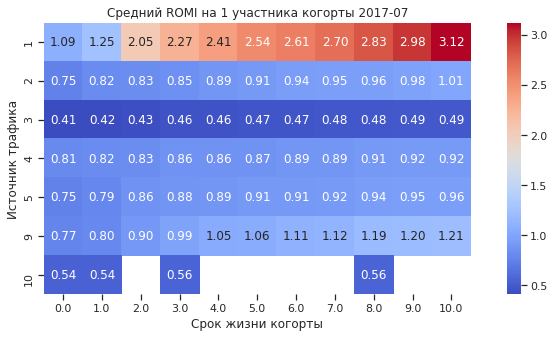

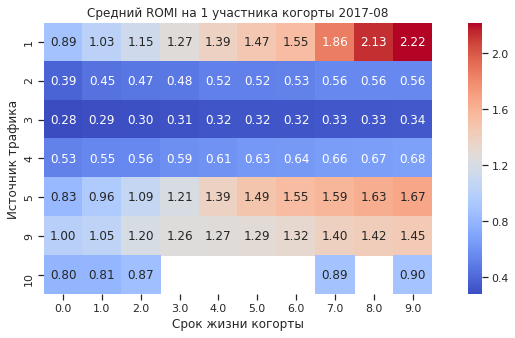

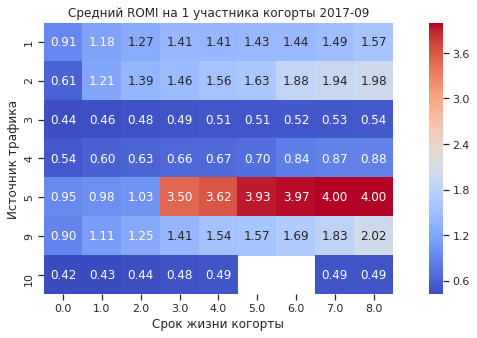

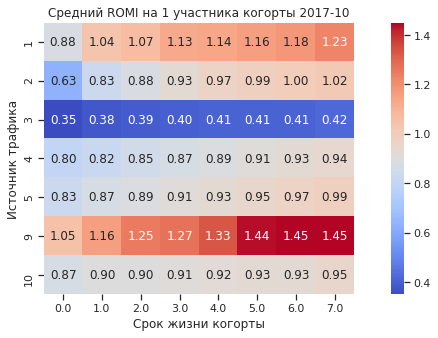

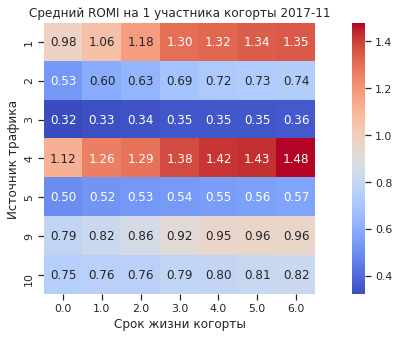

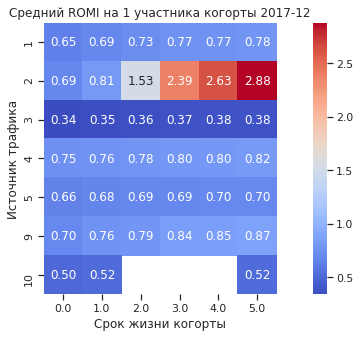

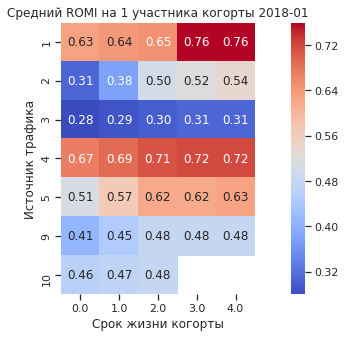

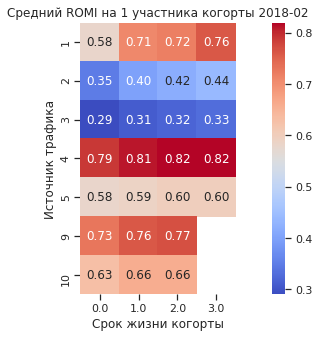

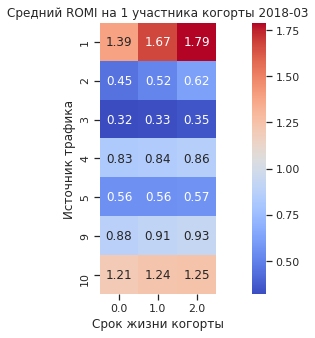

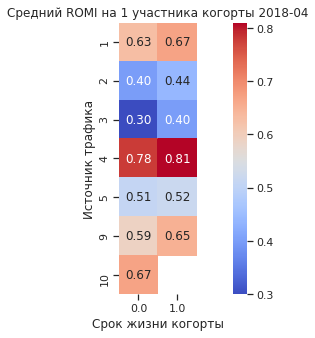

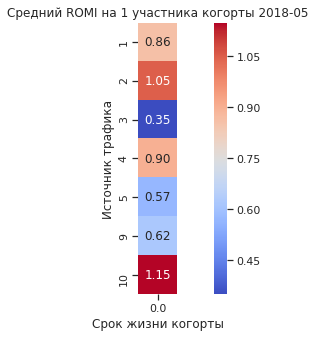

In [140]:
for row in output.index:
    plt.figure(figsize=(13, 5))
    sns.heatmap(
    romi[romi['first_order_month'] == row].pivot_table(
    index='source_id', columns='cohort_lifetime', values='romi', aggfunc='mean'
).cumsum(axis=1).round(2), cmap= 'coolwarm', annot=True, fmt = '.2f', square=True)
    plt.title('Cредний ROMI на 1 участника когорты {:%Y-%m}'.format(row))
    plt.xlabel('Срок жизни когорты')
    plt.ylabel('Источник трафика')

In [141]:
romi_on_month = romi.groupby(['first_order_month', 'source_id']).agg({'revenue' : 'sum'}).reset_index()
romi_on_month = pd.merge(costs_by_source_in_month, romi_on_month, 
                         left_on=['dt_month','source_id'], right_on = ['first_order_month','source_id'])
romi_on_month.drop(columns='dt_month', inplace=True)
romi_on_month['romi'] = romi_on_month['revenue'] / romi_on_month['costs']

Text(221.96857142857147, 0.5, 'Источники трафика')

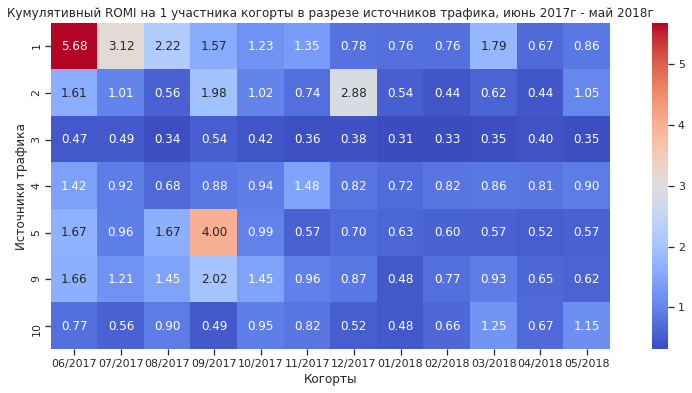

In [142]:
data = romi_on_month.pivot_table(index='first_order_month', columns='source_id', values='romi')
data.index = data.index.strftime("%m/%Y")
plt.figure(figsize=(15, 6))
sns.heatmap(data=data.T, cmap= 'coolwarm', annot=True, fmt = '.2f', square=True)
plt.title('Кумулятивный ROMI на 1 участника когорты в разрезе источников трафика, июнь 2017г - май 2018г')
plt.xlabel('Когорты')
plt.ylabel('Источники трафика')

Наименьший ROMI по всем когортам (за исключением когорты 2017-09) у источника трафика №3 - средняя окупаемость не преодолевает порог в 50%, даже несмотря на то, что первые когорты имеют срок жизни около года.

Интересно, что для разных когорт самым окупаемым становятся разные источники трафика. 
Например:
* источник №1 стал наиболее рентабельным для пяти когорт (2017-06, 2017-07, 2017-08, 2018-01, 2018-03)
* источник №4 стал наиболее рентабельным для трех когорт (2017-11, 2018-02, 2018-04)
* источник №2 стал наиболее рентабельным для 1 когорты (2017-12)
* источник №5 стал наиболее рентабельным для 1 когорты (2017-09)
* источник №9 стал наиболее рентабельным для 1 когорты (2017-10)
* источник №10 стал наиболее рентабельным для 1 когорты (2018-05)

<a id='analysis_conclusion'></a>
## Вывод по шагу 3

Динамика количества уникальных пользователей сервиса в течение года позволяет судить о наличии сезонности в спросе на услуги Яндекс.Афиши:
- низкий спрос в период с апреля по октябрь, где зачение DAU/WAU/MAU ниже среднего и достигают минимальных значений в летние месяцы;
- высокий спрос с октября по апрель, когда DAU/WAU/MAU выше среднего значения с пиком в районе новогодних праздников.

Сезонность можно объяснить несколькими факторами - во-первых, в летние месяцы школьных каникул мероприятия в городе пользуются меньшим спросом из-за того, что люди предпочитают уезжать в отпуск или проводить время на природе; во-вторых, в летнее и окололетнее время закрыт театральный сезон, а спектакли вероятнее всего дают значительную долю покупок на Яндекс.Афише. Пик в новогодние праздники можно объяснить спросом на мероприятия и для взрослых, и для детей - новогодние елки, корпоративные вечера, мероприятия непосредственно в новогоднюю ночь.

Средние значения DAU/WAU/MAU:    
907 уникальных пользователей в день    
5716 уникальных пользователей в неделю    
23228 уникальных пользователей в месяц

Sticky factor за месяц на уровне 4% говорит о довольно низкой вовлеченности пользователей, клиентская база за месяц весьма разнообразна, что можно считать спецификой услуг, предоставляемых сервисом.

Типичное поведение пользователя: в 75% случаев посещение производятся со стационарного компьютера, средний пользователь использует 1 источник трафика, в среднем в год каждый из пользователей заходит на сайт 1.5 раза, а те, кто заходят на сайт в конкретный день, в среднем делают это единожды, проводят на сайте 60 секунд и делают покупку в тот же день, когда был совершен перевый вход на сайт. За полугодовой период на одного покупателя приходится в среднем 1.24 заказа средней стоимостью 5 у.е.

Почти 3/4 всех посещений производятся со стационарных компьютеров и только чуть больше четверти с мобильных устройств. Это может быть вызвано с одной стороны устоявшимся поведением людей, когда для выбора мероприятия человеку удобнее смотреть варианты и программы со стационарного устройства; с другой стороны, возможно, мобильная версия приложения менее удобна пользователям по своим внутренним характеристикам - например, есть какие-то проблемы с отображением контента или отсутствуют какие-то функции, доступные в десктопной версии. 

Средний LTV на 1 участника месячной когорты со сроком жизни минимум 6 месяцев составляет 7.97 у.е., при этом средний CAC на одного покупателя для всего проекта - 9.01 у.е. 

Для увеличения доходной части стоит обратить внимание на удержание клиентов - в настощий момент коэффициент удержания снижается у каждой следующей когорты - если у когорт в 2017г эта метрика на второй месяц жизни составляла порядка 8%, то в когортах марта и апреля 2018г. этот показатель опустился ниже 5%,  а средний retention rate на второй месяц жизни когорт составляет 6.52%.

Когорта 06-2017 показывает наилучшие результаты по удержанию пользователей в сравнении в остальными когортами анализируемого периода. Когорты 08-2017 и 09-2017 показывали хорошую величину retention rate на первых месяцах жизни когорты, но после 4 периода метрика резко снизилась и продолжает снижаться с течением времени. Возможно, пользователям в этих когортах нужен стимул, чтобы вернуться к более высокому показателю retention rate.

Наибольший доход на 1 участника когорты приносит когорта 09-2017 (12,31 у.е. на 1 участника когорты), 4 месяц в данной когорте пришелся на декабрь, и именно эта когорта внесла значительный вклад в выскоие продажи декабря. Вторым результатом LTV за полугодовой период стало 8,36 у.е. на 1 участника когорты 06-2017. Во многих когортах основной вклад в суммарный LTV был заложен в первом месяце существования когорты.

Кроме увеличения доходной части оптимизация затрат может быть позитивным фактором, если как минимум сохраняется эффективность привлечения клиентов и не снижается маржинальный доход, который они приносят.

Затраты на маркетинг в абсолютном выражении не равномерны в течение года - наибольший объем инвестиций в макретинг происходит в период перед новогодними праздниками - это вполне логично, в этот период мы видели пик продаж и по объему, и по средней стоимости заказа. Наименьшие суммы маркетинговых расходов наблюдаются в период с апреля по август, что также выглядит адекватно, учитывая сезонность спроса.

Ежемесячная структура маркетинговых расходов довольно стабильна и соответствует структуре затрат в целом по году - в любой из периодов расходы в источник №3 самые объемные и их доля практически неизменна по периодам (43% от всех маркетинговых затрат или 140 тыс.у.е. за год); затраты в источники 2,4 и 5 составляют порядка 50% бюджета периода (~40-60 тыс.у.е. в год), оставшиеся 3 источника (№1, 10 и 9) составляют порядка 10% бюджета.

Несмотря на то, что инвестиции в канал №3 наибольшие (140 тыс.у.е. за год), при этом этот источник трафика имеет наименьший ROMI по всем проанализированным когортам (за исключением когорты 2017-09), а средняя окупаемость не преодолевает порог в 50%. Данный источник трафика показывает себя наименее эффективным и является первым претендентом на сокращение инвестиций в данный канал, однако стоит обратить внимание, что данный источник является довольно массовым - из него было совершено 85,6 тыс. посещений за анализируемый период, что составляет почти 24% всех посещений за год.

По источнику №2 средняя стоимость привлечения клиентов составила 10,08 у.е. за анализируемый год. Это также относительно дорогой источник для привлечения клиентов, в среднем инвестиции в этот источник окупаются на 5 месяц жизни когорт. 47,6 тыс. пользователей перешли именно с этого источника (13,3% всех посещений за год), но совокупность перечисленных 2 факторов снижают привлекательность данного источника трафика для бизнеса.

Источники 5, 1 и 4 имеют средний уровень САС от 5,4 до 6,8 у.е. на покупателя и их можно выделить в группу источников со средней стоимостью привлечения клиентов. При этом источник №1 имеет самый быстрый период окупаемости (в среднем на 2 месяц жизни когорт), 5 источник окупается в среднем на 4 месяц жизни когорт, а 4 источник окупается спустя без малого год. Наиболее интересным источником становится первый из-за баланса в стоимости и окупаемости, но он дает не так много пользователей (34 тыс., что составляет 9,5% посещений за год), а также выделим более популярный 5 источник (67 тыс. пользователей, 18,6% посещений). 4 источник хоть и имеет долгий срок окупаемости, но является самым многочисленным и отказываться от него не рекомендуется (102 тыс. пользователей, 28,3% всех посещений)

Оставшиеся 2 источника (10 и 9) имеют средний уровень САС в районе 4 у.е. на покупателя и эту группу условно можно обозначить как дешевые источники привлечения клиентов. При этом 9 источник имеет неплохой период окупаемости (в среднем на 4 месяц жизни когорт), а вот 10 источник не окупается. В этой группе наиболее интересен источник №9, хотя через него произошло всего 3,7% всех посещений за год.

Следует отметить, что для разных когорт самым окупаемым становятся разные источники трафика, но в основном это источники №1 (у 5 когорт) и №4 (у 3 когорт).

<a id='total_conclusion'></a>
## Общий вывод

Целью ставился анализ расходов на маркетинг, чтобы отказаться от невыгодных источников трафика и перераспределить бюджет.

Для этого были проанализированы 3 датасета, содержащие информацию о посещениях, покупках и маркетинговых затратах в период с начала июня 2017г по конец мая 2018г. 

Количество уникальных пользователей за анализируемый период: 228169 человек    
Количество уникальных покупателей: 36523 человека     
Суммарная стоимость всех заказов:  252053.78 у.е.    
Суммарные затраты на маркетинг:    329131.62 у.е.    

Выявленные особенности бизнеса:
- наличие фактора сезонности (высокий сезон с октября по апрель, пик в новогодние праздники),
- рекламные кампании длятся на протяжении почти всего календарного года, за исключением 1-2 дней,
- наиболее массовыми являются когорты, сформированные с октября по март, в среднем когорты в сезон и не-сезон отличаются по размеру на 40%,
- наибольшая стоимость привлечения клиента наблюдается в периоды с низким спросом,
- наименьшие значения среднего чека на заказ наблюдаются в июне и январе, максимальный - в декабре,
- средний LTV на 1 участника месячной когорты со сроком жизни минимум 6 месяцев составляет 7.97 у.е., 
- средний CAC на одного покупателя - 9.01 у.е.,
- наибольший объем инвестиций в макретинг происходит в период перед новогодними праздниками,
- самые окупаемые источники трафика по когортам - источник №1 и №5,
- самые неэффективные источники трафика - источник №3 и №10,
- самый массовый источник трафика - №4,
- наиболее результативные когорты по доходу на 1 участника: 09-2017 и 06-2017,
- наилучшие результаты по удержанию у когорт 06-2017, 08-2017 и 09-2017.

Типичное поведение пользователя: 3/4 всех посещений производятся со стационарных компьютеров, средний пользователь использует 1 источник трафика, в среднем в год каждый из пользователей заходит на сайт 1.5 раза, а те, кто заходят на сайт в конкретный день, в среднем делают это единожды, проводят на сайте 60 секунд и делают покупку в тот же день, когда был совершен перевый вход на сайт. За полугодовой период на одного покупателя приходится в среднем 1.24 заказа средней стоимостью 5 у.е.

В абсолютном выражении затраты на макретинг превысили доходы от пользования сервисом, что является тревожным сигналом для бизнеса, и хоть наметился тренд на снижение CAC, необходимо рассмотреть возможные факторы роста выручки и сценарии для сокращения непродуктивных затрат, особенно в низкий сезон.

Для увеличения доходной части стоит обратить внимание на удержание клиентов и повышение метрики retention rate. Кроме увеличения доходной части оптимизация маркетинговых затрат может быть позитивным фактором, если как минимум сохраняется эффективность привлечения клиентов и не снизится маржинальный доход, который они приносят.


Рекомендации:

1. Рассмотреть возможность сокращения инвестиций в источник трафика №3 и №10. Основные инвестиции рекомендуется направлять в источники №5, №1 и №4.
2. Учитывать сезонность спроса при проведении маркетинговых мероприятий и распределении бюджета в рамках года.
3. Новых клиентов при привлечении стоит стимулировать к повышению среднего чека, т.к. во многих когортах основной вклад в суммарный LTV закладывается в первом месяце существования когорты и в дальнейшем влияет на окупаемость инвестиций в маркетинг. Скидочные мероприятия стоит предлагать клиентам когорт, где после нескольких месяцев на высоком уровне резко снизился уровень retention rate.
4. В период новогодних праздников рекомендуется проводить стимулирование, направленное и на увеличение количества заказов, и на увеличение средней стоимости заказа. 
5. Проводить анализ наиболее окупаемых источников трафика в разрезе когорт для направления инвестиций в наиболее окупаемый канал по каждой из когорт.
6. Необходимо проверить, что в мобильной версии отсутствуют проблемы, из-за которых пользователи проводят на сайте меньше времени и, возможно, совершают меньше заказов.